In [3]:
import numpy as np
import pandas as pd

import theano.tensor as tt
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

In [11]:
data = pd.read_excel("raw_data/data/Conley_Onder_JEPdata.xlsx")
data["AERPub_adj"] = data["AERPub"].apply(lambda x: x+0.001)
data["AERPub_int"] = data["AERPub"].apply(lambda x: x*100 // 1)
data.head()

PhD_ID  Rank  Year    AERPub  AERPub_adj  AERPub_int
0     590     1  1987  7.054300    7.055300       705.0
1    2971     1  1992  6.452617    6.453617       645.0
2     210     1  1986  5.183317    5.184317       518.0
3    2992     1  1993  4.700700    4.701700       470.0
4    6544     1  1998  4.306967    4.307967       430.0

# Simple Poisson model

Model the number of papers published as poisonnian looking for lambda.

In [14]:
z = data.AERPub_adj

num_schools = 31

coords = {"obs_id": np.arange(data.index.size), "SchoolRank": np.arange(num_schools + 1)}
with pm.Model(coords=coords) as simple_model:
#     rank_idx = pm.Data("rank_idx", data.Rank.values, dims="obs_id")
    
#     # Create a mean for each school
#     a = pm.HalfNormal("a", sd=1)
#     b = pm.Normal("b", mu=7.5, sd=2)
#     mu = pm.Beta("mu", a, b, dims="SchoolRank")
#     school_mu = mu[rank_idx]

#     shape_up = pm.Uniform("shape_up", 0,1)
# #     rate_up = pm.Normal("rate_up", mu=4.5, sd=1)
#     rate_mu = pm.Uniform("rate_mu", 4,6)
    
#     rate = pm.Normal("school_rate", rate_mu, 1, dims="SchoolRank")
#     school_rate = rate[rank_idx]    

#     shape = pm.Uniform("school_shape", 0, shape_up, dims="SchoolRank")
#     school_shape = shape[rank_idx]
    
    

    rank_idx = pm.Data("rank_idx", data.Rank.values, dims="obs_id")
    
    # Create a mean for each school
#     a = pm.HalfNormal("a", sd=1)
#     b = pm.Normal("b", mu=7.5, sd=2)
    
    shape = pm.Uniform("shape", 0,10)
    rate = pm.Uniform("rate", 1,50)
    
    mu = pm.Gamma("mu", shape, rate, dims="SchoolRank")
    school_mu = mu[rank_idx]
    
    y = pm.Poisson('y', mu=school_mu, observed = z, dims="obs_id")

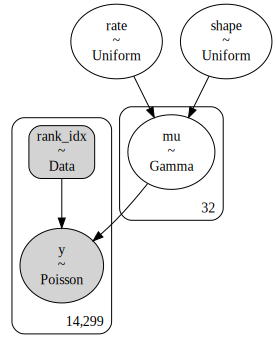

In [15]:
pm.model_to_graphviz(simple_model)

In [16]:
with simple_model:
    simple_idata = pm.sample(draws=2000, tune=3000, return_inferencedata=True)
    
# simple_idata = simple_idata.sel(SchoolRank = np.arange(1,32))
simple_idata_a = simple_idata.sel(SchoolRank = np.arange(1,16))
simple_idata_b = simple_idata.sel(SchoolRank = np.arange(16,32))
simple_idata_z = simple_idata.sel(SchoolRank = np.arange(1,32))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, rate, shape]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 30 seconds.


### Next steps

It looks like the chains mixed, so can evaluate and criticize the trace:  
- Check the summary.
  - Verify  𝑟ℎ𝑎𝑡<1.01 
  - Verify ESS is roughly  >= 50% of raw sample size
  - Check the HDI for any params
- Check a trace plot. See if the chains mixed.
- Check the forest plot - look for uncertainty in estimates and variance in chains
- Check autocorrelation plot. Verify that the chains aren't too heavily autocorrelated.

In [27]:
simple_idata_z = simple_idata.sel(SchoolRank = np.arange(1,32))
az.summary(simple_idata_z)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
shape    1.262  0.310   0.729    1.857      0.004    0.003    5526.0   5260.0   
rate    12.157  3.545   5.647   18.516      0.046    0.033    5972.0   5645.0   
mu[0]    0.280  0.025   0.233    0.326      0.000    0.000   15415.0  14842.0   
mu[1]    0.155  0.019   0.121    0.192      0.000    0.000   13713.0  13002.0   
mu[2]    0.143  0.022   0.103    0.186      0.000    0.000   15051.0  14167.0   
mu[3]    0.165  0.021   0.127    0.203      0.000    0.000   15658.0  15044.0   
mu[4]    0.343  0.030   0.288    0.399      0.000    0.000   12761.0  12506.0   
mu[5]    0.091  0.015   0.064    0.117      0.000    0.000   14932.0  13381.0   
mu[6]    0.178  0.032   0.119    0.240      0.000    0.000   14727.0  13557.0   
mu[7]    0.210  0.029   0.157    0.266      0.000    0.000   13354.0  12824.0   
mu[8]    0.041  0.012   0.020    0.063      0.000    0.000   12982.0  11324.0   
mu[9]    0.089  0.018   0.056    0.121      0.000    0.000   13855.0  12604.0   
mu[10]   0.311  0.035   0.245    0.377      0.000    0.000   13776.0  13776.0   
mu[11]   0.065  0.015   0.037    0.094      0.000    0.000   11723.0  11324.0   
mu[12]   0.049  0.016   0.020    0.080      0.000    0.000   12721.0  10572.0   
mu[13]   0.038  0.012   0.017    0.060      0.000    0.000   13614.0  11344.0   
mu[14]   0.060  0.012   0.037    0.083      0.000    0.000   13668.0  12959.0   
mu[15]   0.056  0.021   0.020    0.094      0.000    0.000   15098.0  11833.0   
mu[16]   0.009  0.006   0.000    0.020      0.000    0.000   12126.0   8821.0   
mu[17]   0.029  0.012   0.010    0.052      0.000    0.000   15044.0  11381.0   
mu[18]   0.276  0.045   0.195    0.365      0.000    0.000   13710.0  12871.0   
mu[19]   0.014  0.009   0.000    0.030      0.000    0.000   12293.0   8544.0   
mu[20]   0.100  0.017   0.068    0.131      0.000    0.000   15547.0  13874.0   
mu[21]   0.013  0.006   0.004    0.023      0.000    0.000   14096.0  11254.0   
mu[22]   0.031  0.017   0.005    0.063      0.000    0.000   14051.0  10802.0   
mu[23]   0.122  0.034   0.064    0.188      0.000    0.000   14141.0  11940.0   
mu[24]   0.066  0.029   0.018    0.120      0.000    0.000   14792.0  10978.0   
mu[25]   0.127  0.035   0.065    0.192      0.000    0.000   14208.0  12393.0   
mu[26]   0.062  0.027   0.016    0.112      0.000    0.000   13147.0  10475.0   
mu[27]   0.026  0.011   0.007    0.047      0.000    0.000   13407.0  11190.0   
mu[28]   0.019  0.013   0.000    0.042      0.000    0.000   14091.0   9723.0   
mu[29]   0.125  0.054   0.036    0.228      0.000    0.000   13313.0  10487.0   
mu[30]   0.015  0.001   0.012    0.017      0.000    0.000   15705.0  15498.0   

        ess_bulk  ess_tail  r_hat  
shape     5691.0    5295.0    1.0  
rate      6091.0    5389.0    1.0  
mu[0]    15140.0    5911.0    1.0  
mu[1]    13838.0    6167.0    1.0  
mu[2]    15006.0    5724.0    1.0  
mu[3]    15598.0    5876.0    1.0  
mu[4]    12776.0    6116.0    1.0  
mu[5]    14963.0    4747.0    1.0  
mu[6]    14530.0    5115.0    1.0  
mu[7]    13341.0    5920.0    1.0  
mu[8]    12671.0    5245.0    1.0  
mu[9]    13805.0    6353.0    1.0  
mu[10]   13581.0    5710.0    1.0  
mu[11]   11015.0    5209.0    1.0  
mu[12]   12047.0    5752.0    1.0  
mu[13]   13188.0    5813.0    1.0  
mu[14]   13086.0    5635.0    1.0  
mu[15]   14561.0    5133.0    1.0  
mu[16]   10563.0    5007.0    1.0  
mu[17]   14984.0    6034.0    1.0  
mu[18]   13627.0    5410.0    1.0  
mu[19]   11496.0    5126.0    1.0  
mu[20]   15693.0    5879.0    1.0  
mu[21]   13256.0    5580.0    1.0  
mu[22]   12411.0    5353.0    1.0  
mu[23]   14197.0    5917.0    1.0  
mu[24]   14339.0    5536.0    1.0  
mu[25]   13989.0    5561.0    1.0  
mu[26]   12075.0    5262.0    1.0  
mu[27]   12488.0    5694.0    1.0  
mu[28]   12574.0    4932.0    1.0  
mu[29]   12882.0    5622.0    1.0  
mu[30]   15586.0    5856.0    1.0

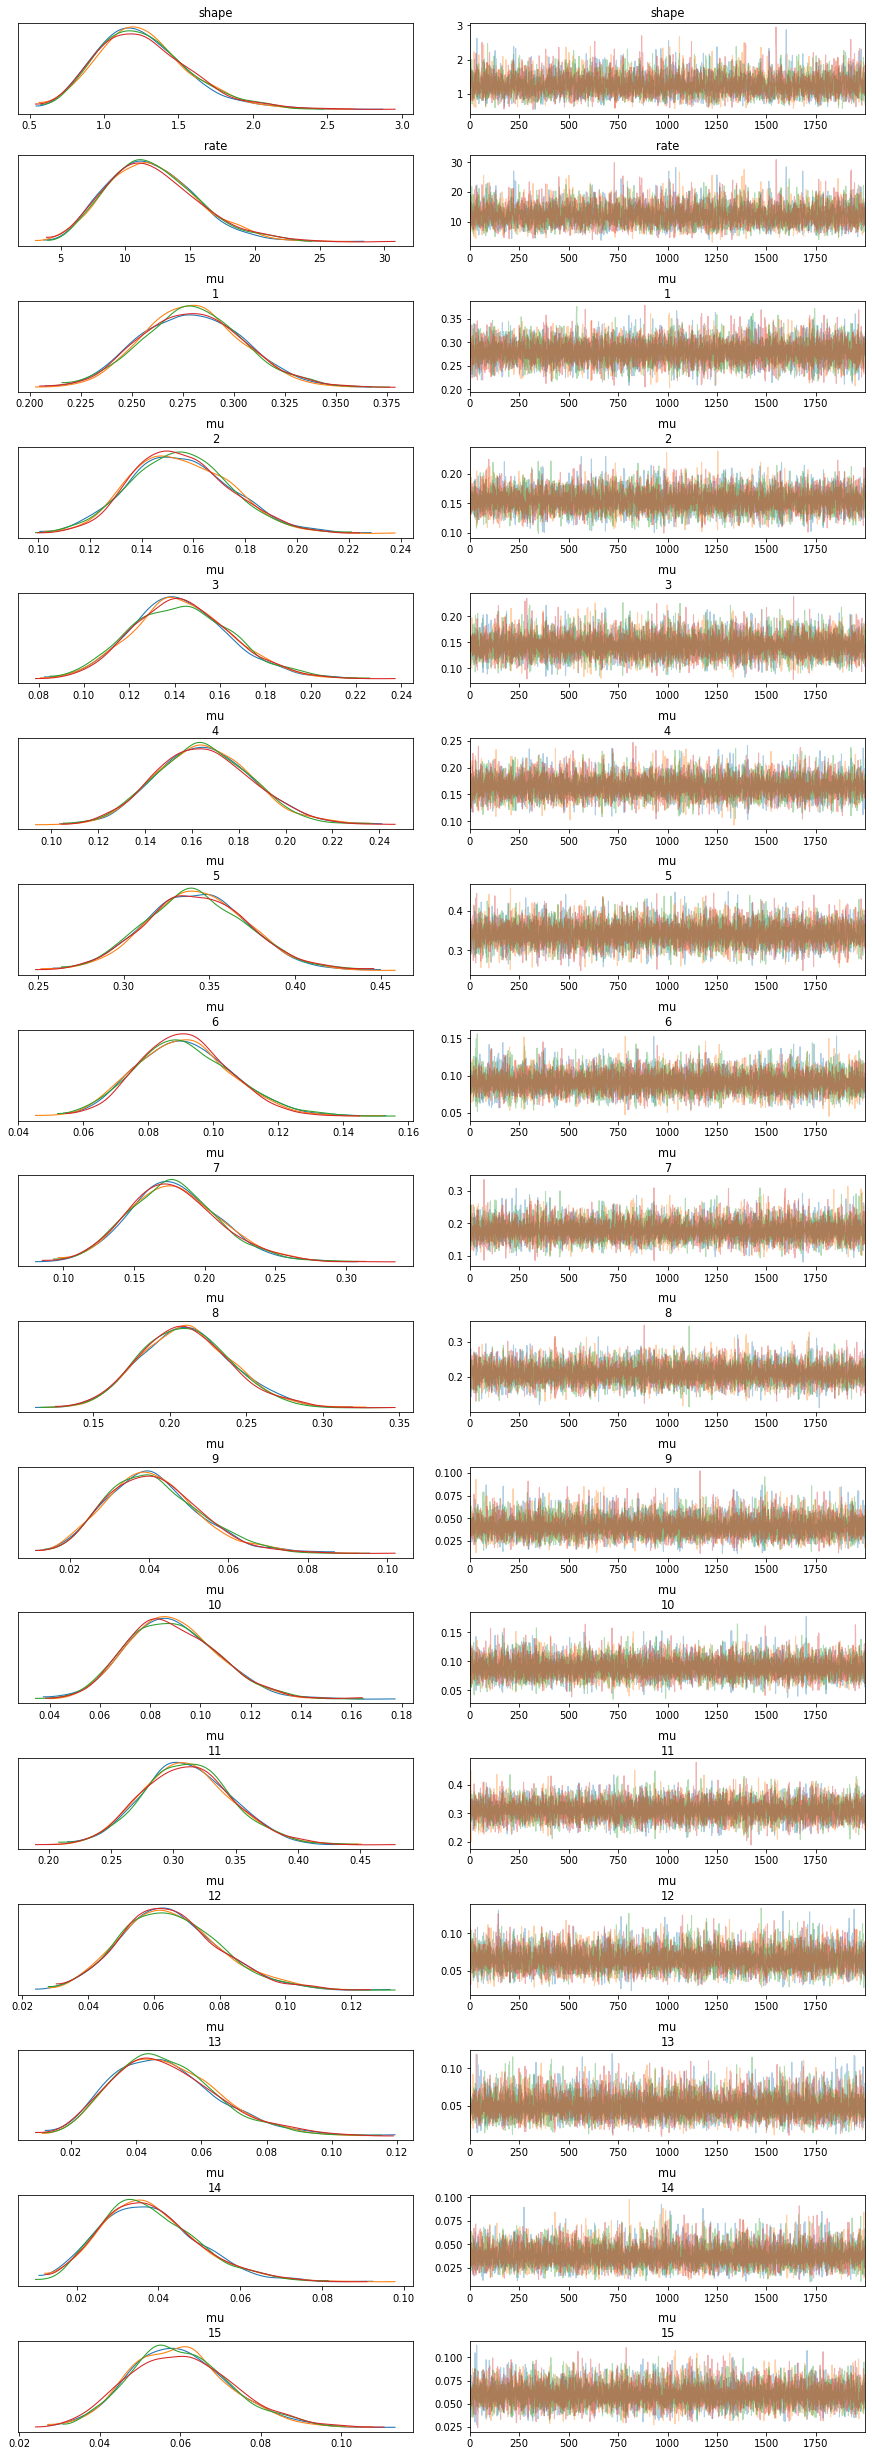

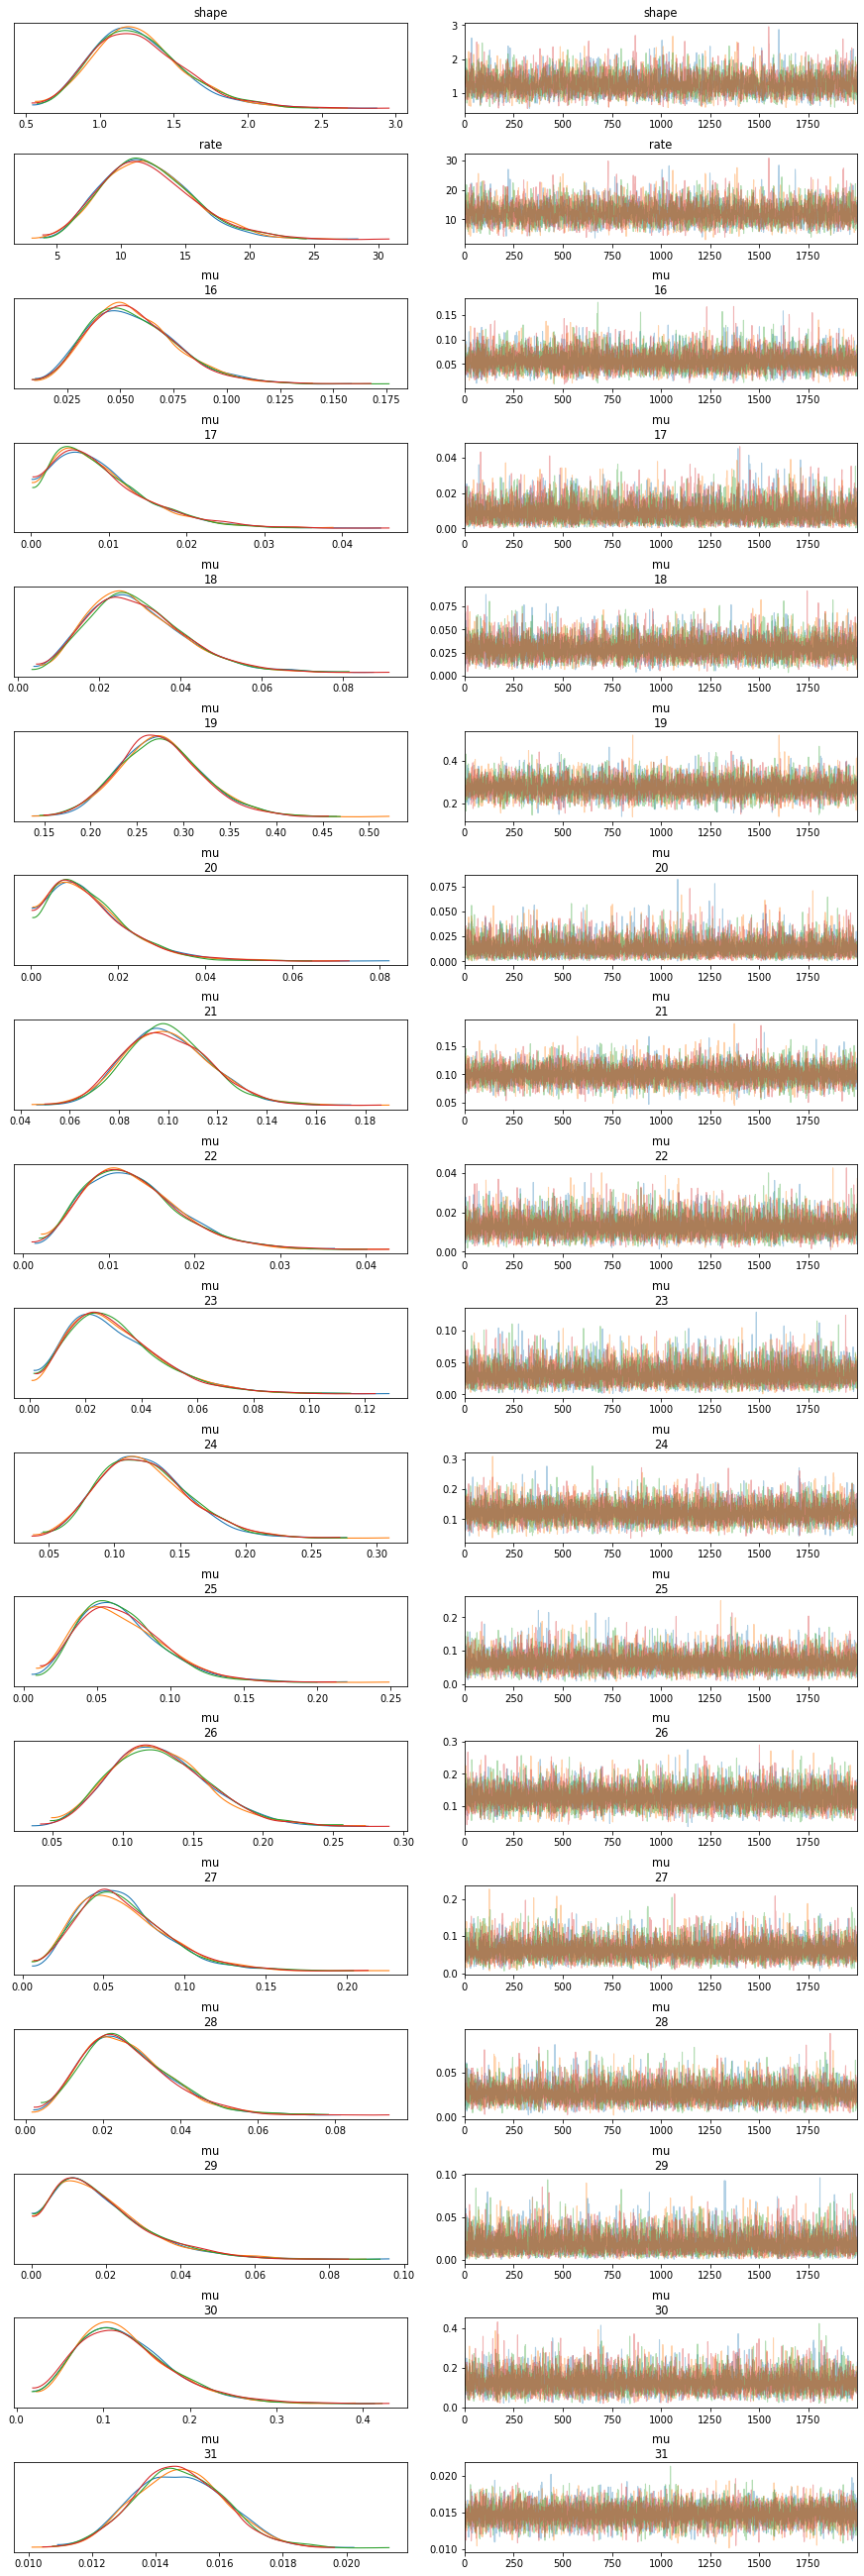

In [18]:
az.plot_trace(simple_idata_a);
az.plot_trace(simple_idata_b);

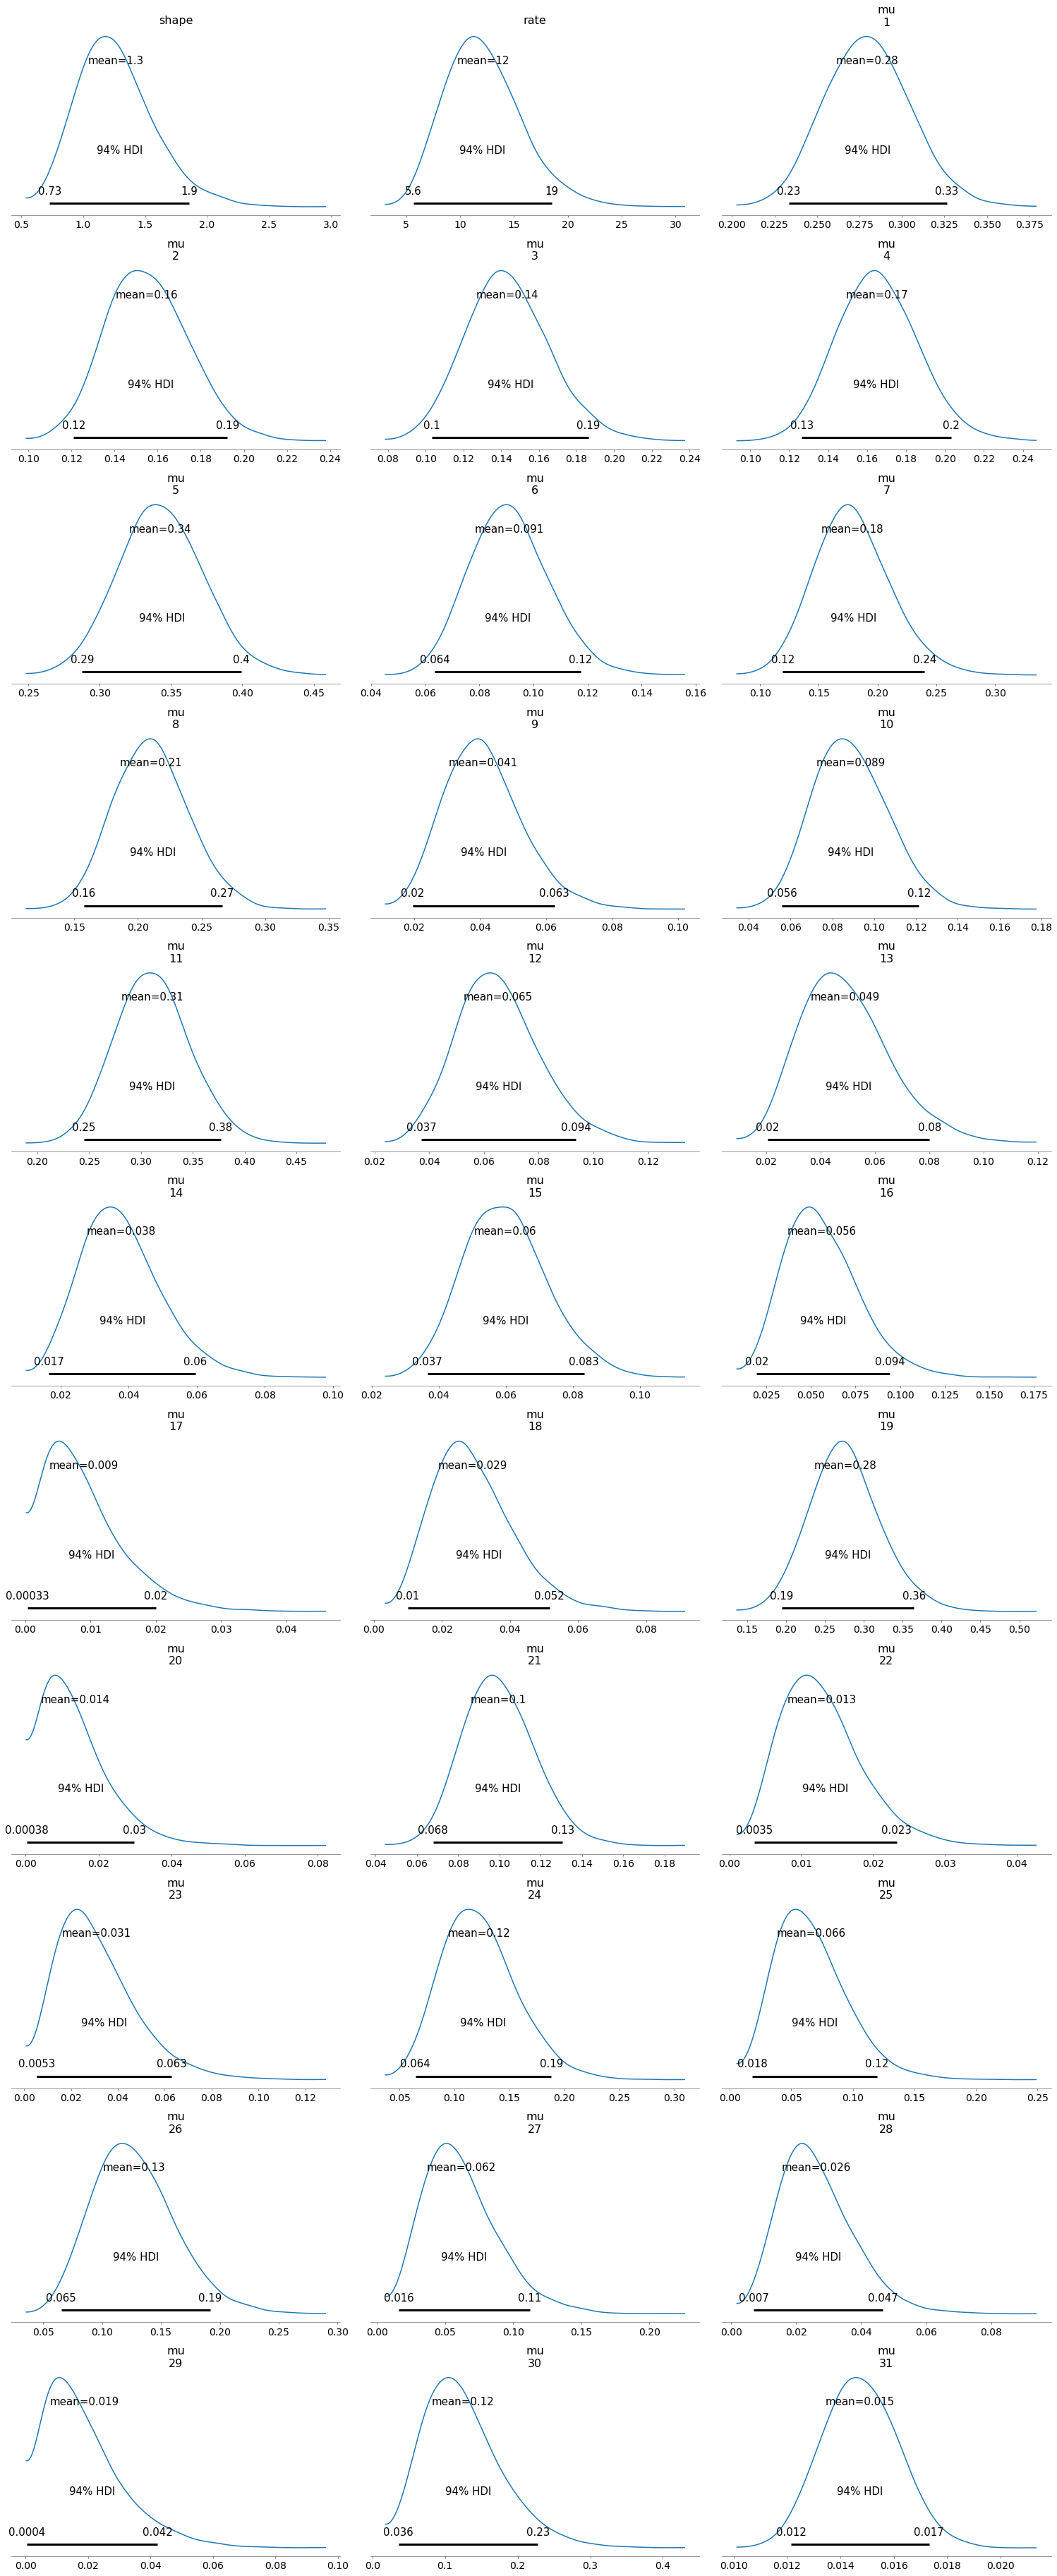

In [28]:
az.plot_posterior(simple_idata_z);

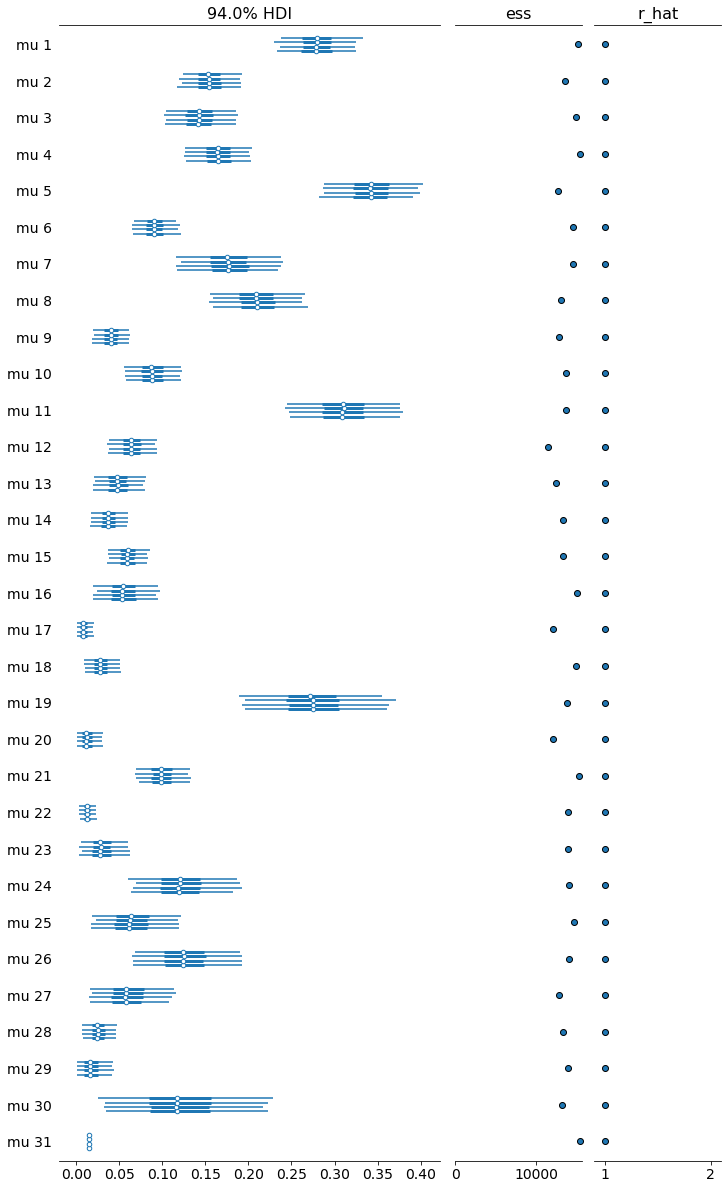

In [29]:
az.plot_forest(simple_idata_z, r_hat=True, ess=True, var_names=["mu"]);

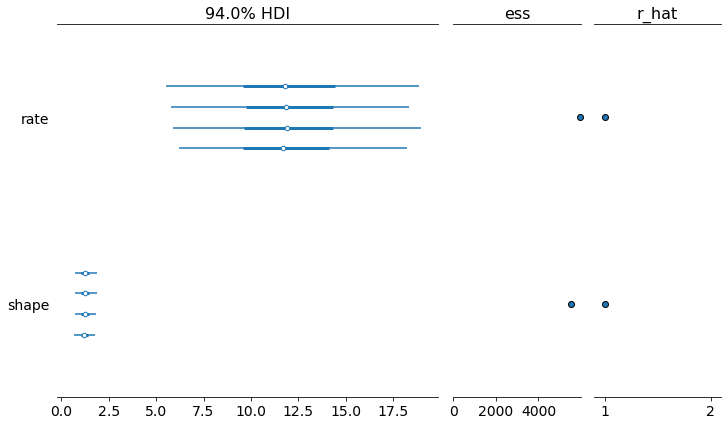

In [31]:
az.plot_forest(simple_idata, r_hat=True, ess=True, var_names = ["rate", "shape"]);

/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:563: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (68) in plot_autocorr, generating only 40 plots
  UserWarning,
/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:563: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (72) in plot_autocorr, generating only 40 plots
  UserWarning,


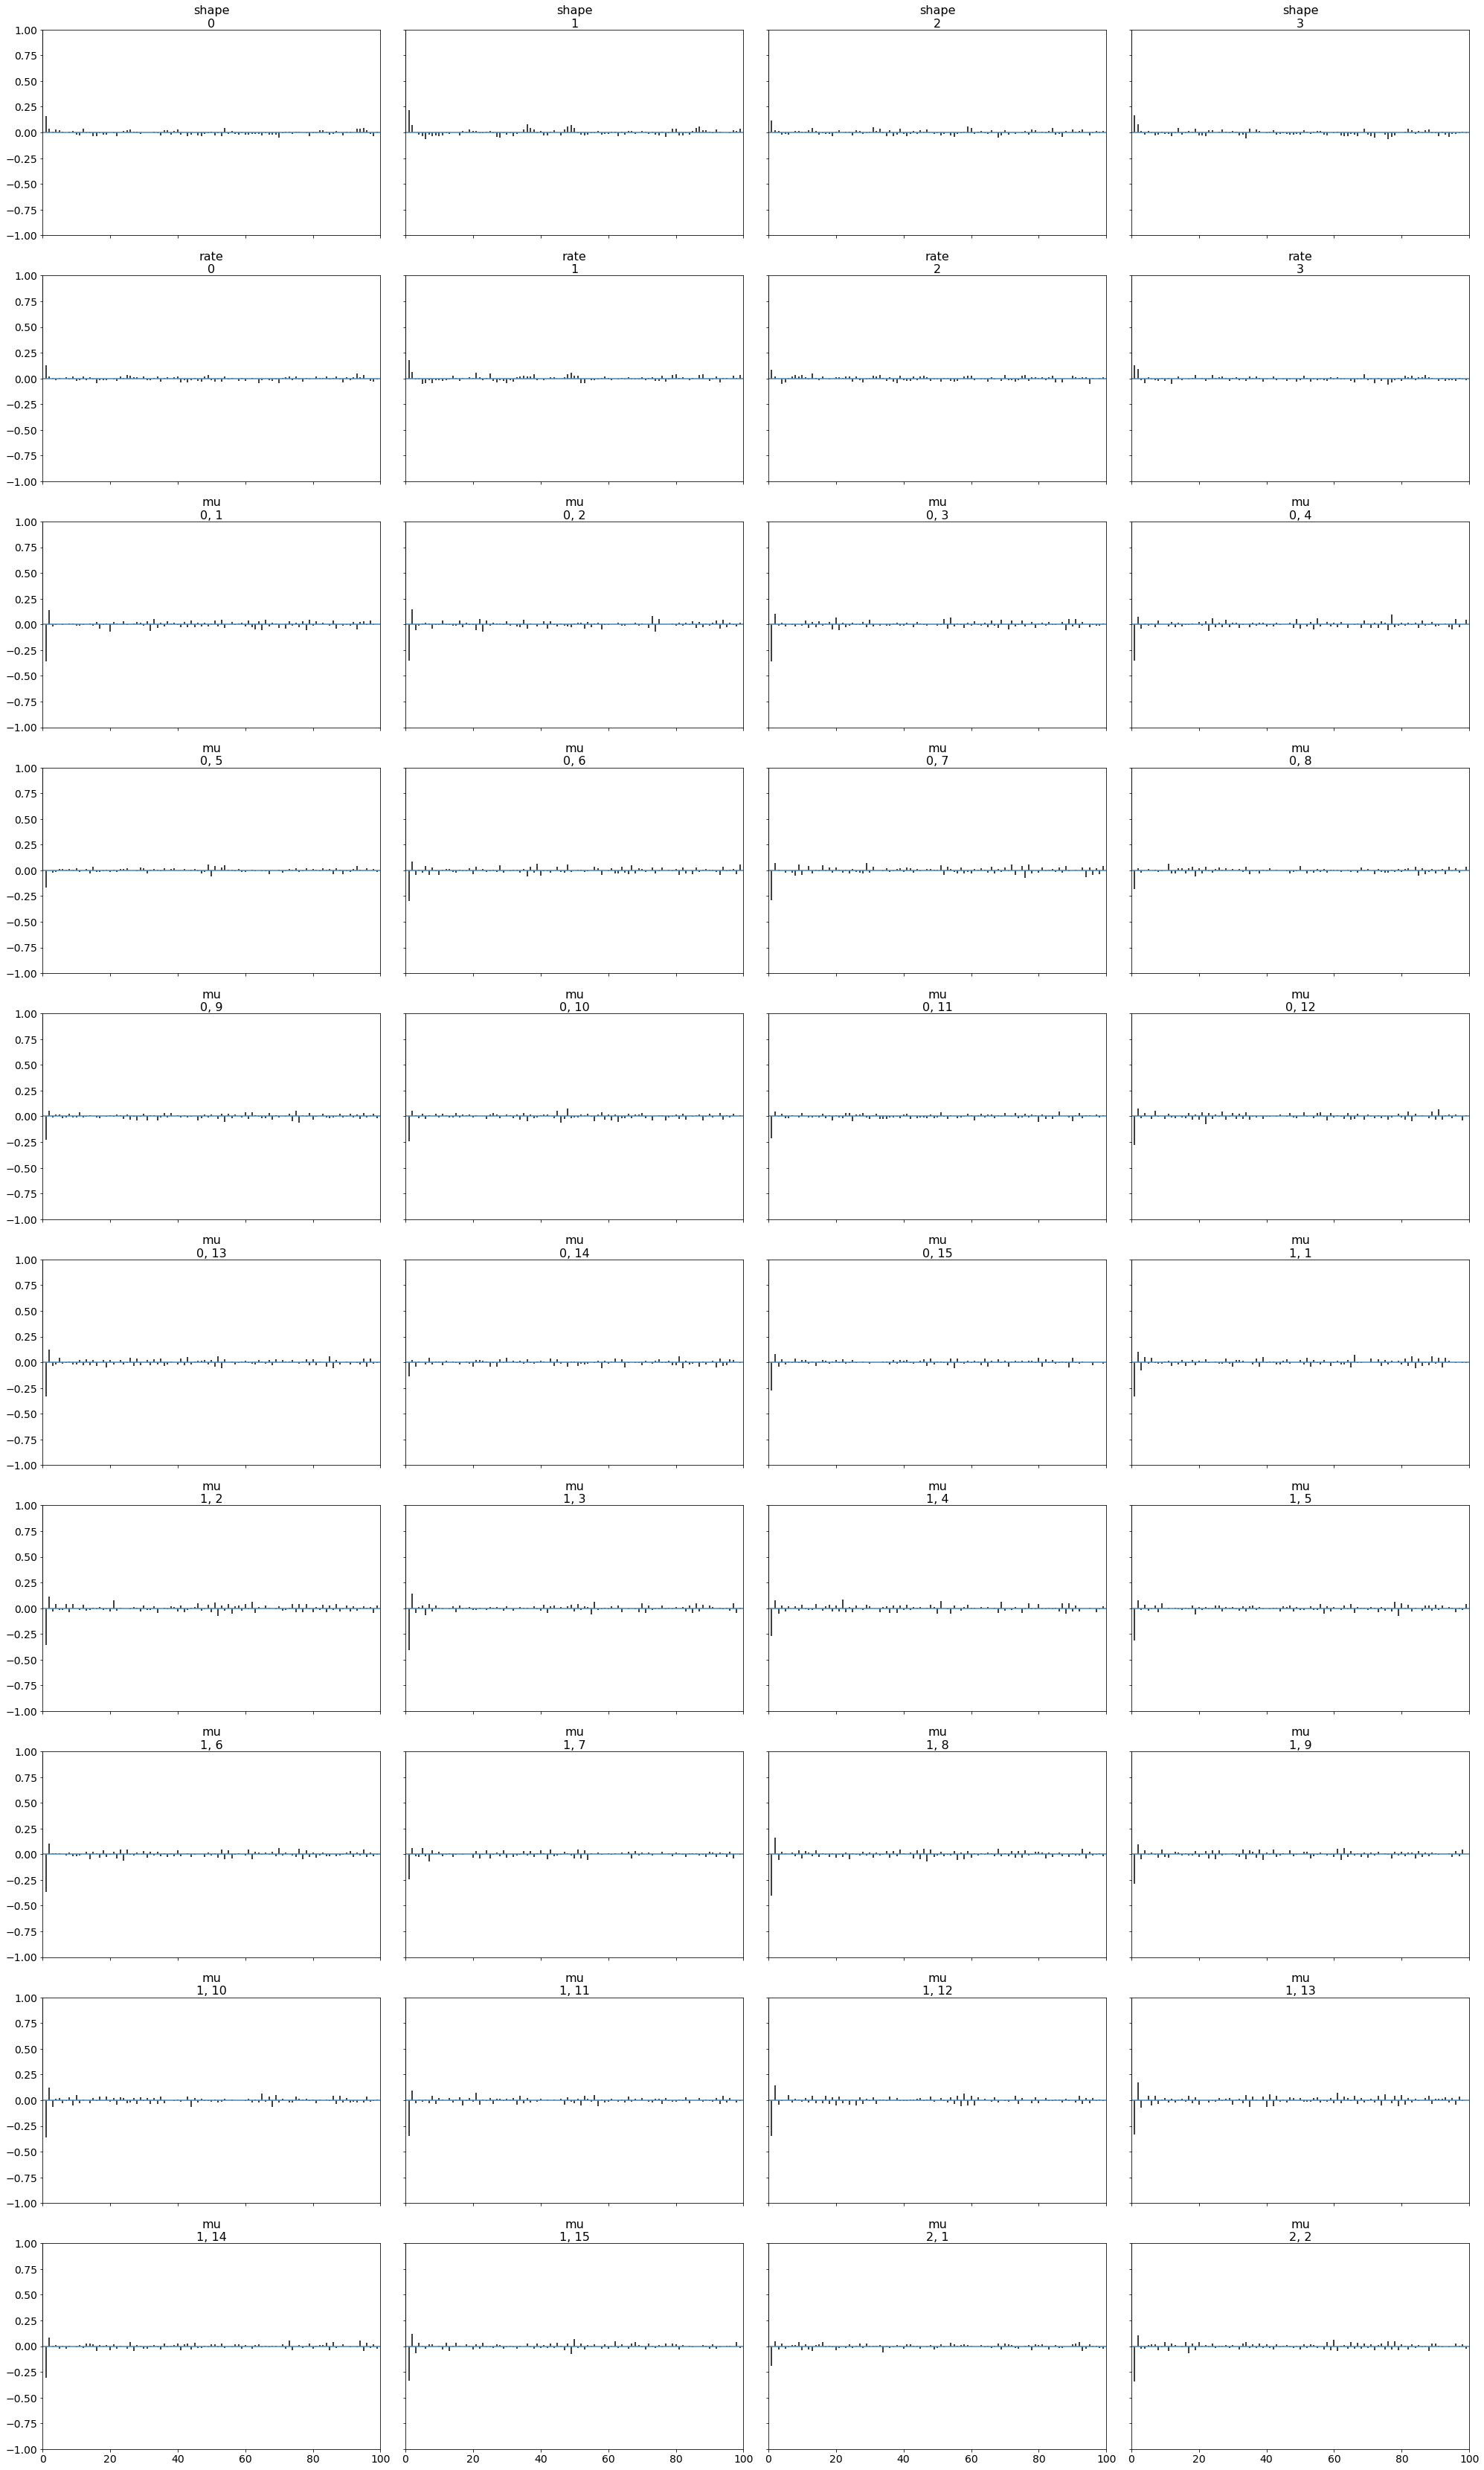

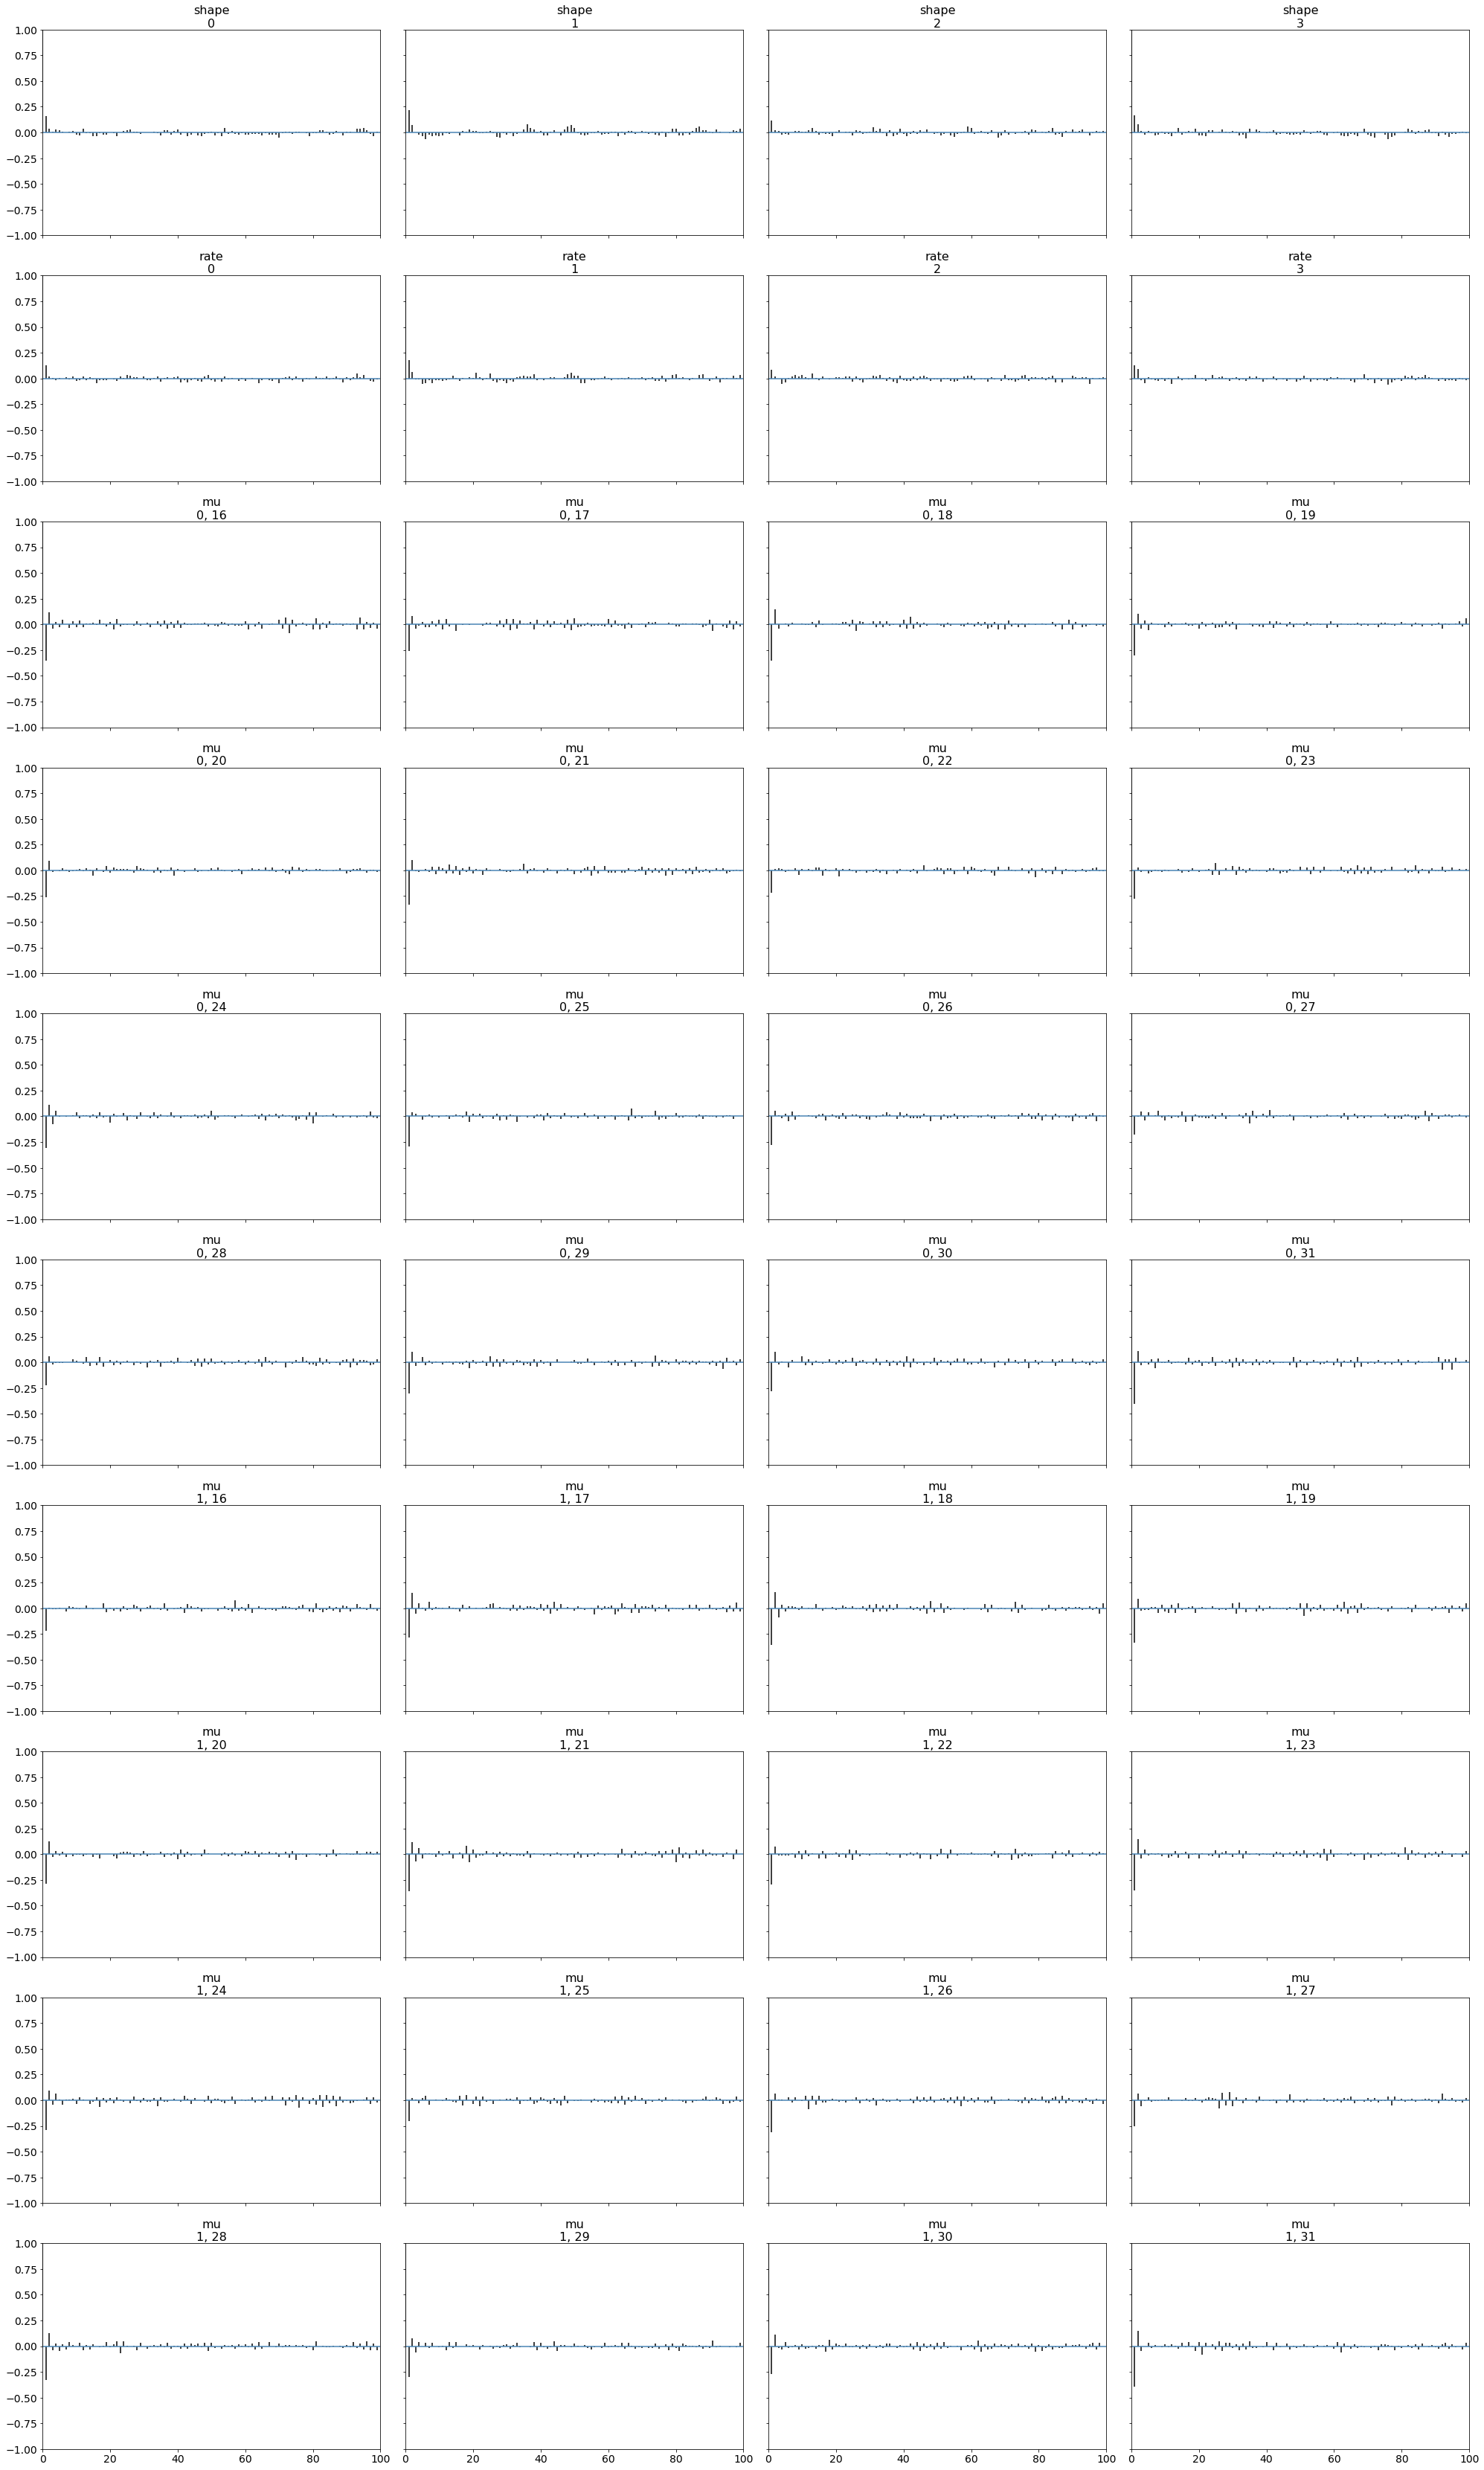

In [20]:
az.plot_autocorr(simple_idata_a);
az.plot_autocorr(simple_idata_b);

### Plot the posterior

See how the model compares to the observed data. Consider one plot per school rank.

Though in theory the output of a graduate is discrete the variable is actually continuous because of the AER equivalence measure.

In [21]:
with simple_model:
     py_simple_posterior_samples = pm.sample_posterior_predictive(simple_idata.posterior)

simple_posterior_samples = az.from_pymc3(posterior_predictive = py_simple_posterior_samples)
concat_simple_posterior = az.concat(simple_idata, simple_posterior_samples, inplace=False)

/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


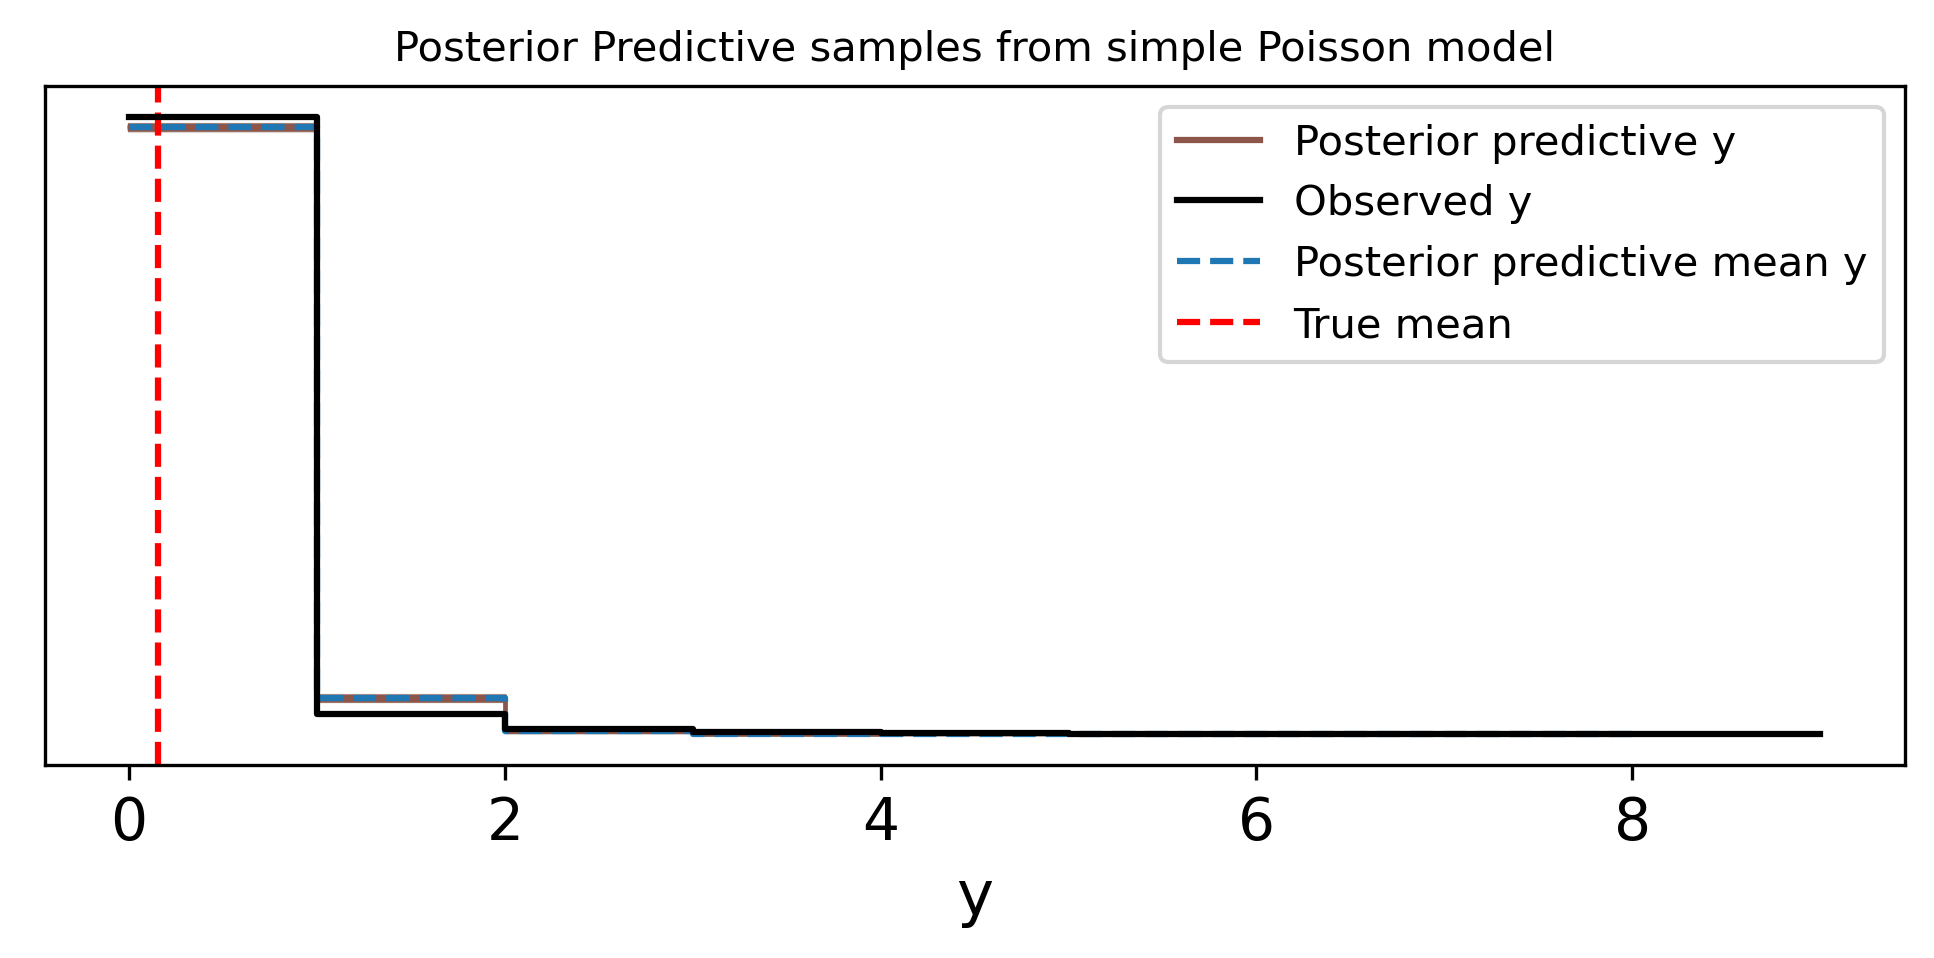

In [22]:
fig, ax = plt.subplots(figsize=(8,3));
fig.set_dpi(300);
az.plot_ppc(concat_simple_posterior, ax=ax, num_pp_samples=100);
ax.axvline(data.AERPub_adj.mean(), ls="--", color="r", label="True mean");
ax.set_title("Posterior Predictive samples from simple Poisson model", fontsize=10)
ax.legend(fontsize=10, loc=1);

# Simple Halfnormal 

In [8]:
z = data.AERPub_adj

num_schools = 31

coords = {"obs_id": np.arange(data.index.size), "SchoolRank": np.arange(num_schools + 1)}
with pm.Model(coords=coords) as simple_normal_model:
    rank_idx = pm.Data("rank_idx", data.Rank.values, dims="obs_id")
    
    # Create a mean for each school
#     scale_school = pm.Uniform("scale_school", 0, 3)
#     rate_school = pm.Uniform("rate_school", 1, 5)
#     sdev = pm.Gamma("sdev_school", scale_school, rate_school, dims="SchoolRank")
#     school_sdev = sdev[rank_idx]
    
#     y = pm.HalfNormal('y', sd=school_sdev, observed = z, dims="obs_id")



#     shape_up_norm = pm.Normal("Shape", mu=1, sd=0.5)
#     shape_up = pm.Deterministic(np.max(shape_up_norm, 0))
    shape_up = pm.Uniform("shape_up", 0,1)
#     rate_up = pm.Normal("rate_up", mu=4.5, sd=1)
    rate_mu = pm.Uniform("rate_mu", 4,6)
    
    rate = pm.Normal("school_rate", rate_mu, 1, dims="SchoolRank")
    school_rate = rate[rank_idx]    

    shape = pm.Uniform("school_shape", 0, shape_up, dims="SchoolRank")
    school_shape = shape[rank_idx]
    y = pm.Gamma("y", alpha=school_shape, beta=school_rate, observed=z, dims="obs_id")

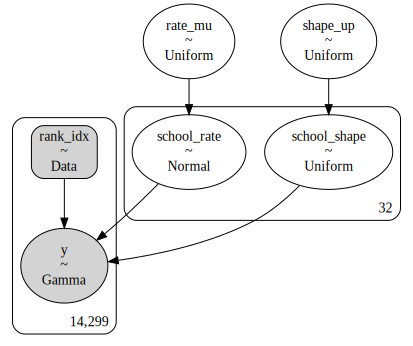

In [9]:
pm.model_to_graphviz(simple_normal_model)

In [10]:
with simple_normal_model:
    simple_idata_normal = pm.sample(draws= 1500, tune=2000, return_inferencedata=True)
    
simple_idata_normal_a = simple_idata_normal.sel(SchoolRank = np.arange(1,16))
simple_idata_normal_b = simple_idata_normal.sel(SchoolRank = np.arange(16,32))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [school_shape, school_rate, rate_mu, shape_up]


Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 173 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5623105819183251, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
simple_idata_normal.to_netcdf("raw_data/simple_gamma.nc")

'raw_data/simple_gamma.nc'

In [6]:
az.summary(simple_idata_normal)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
shape_up          0.377  0.025   0.334    0.424      0.001    0.001     325.0   
rate_up           4.762  0.131   4.551    5.000      0.003    0.002    1991.0   
school_rate[0]    2.383  1.375   0.104    4.571      0.021    0.015    4432.0   
school_rate[1]    0.577  0.060   0.469    0.691      0.001    0.001    4587.0   
school_rate[2]    0.840  0.091   0.671    1.007      0.001    0.001    4441.0   
...                 ...    ...     ...      ...        ...      ...       ...   
school_shape[27]  0.252  0.032   0.193    0.310      0.001    0.000    2511.0   
school_shape[28]  0.261  0.021   0.223    0.299      0.000    0.000    3440.0   
school_shape[29]  0.292  0.029   0.236    0.345      0.001    0.000    2982.0   
school_shape[30]  0.306  0.045   0.219    0.384      0.001    0.001    1800.0   
school_shape[31]  0.276  0.003   0.269    0.282      0.000    0.000    4373.0   

                  ess_sd  ess_bulk  ess_tail  r_hat  
shape_up           325.0     333.0     748.0   1.01  
rate_up           1973.0    1765.0    1662.0   1.00  
school_rate[0]    4094.0    4338.0    3347.0   1.00  
school_rate[1]    4457.0    4675.0    3623.0   1.00  
school_rate[2]    4441.0    4424.0    4217.0   1.00  
...                  ...       ...       ...    ...  
school_shape[27]  2336.0    2619.0    2307.0   1.00  
school_shape[28]  3281.0    3582.0    2881.0   1.00  
school_shape[29]  2745.0    3055.0    1935.0   1.00  
school_shape[30]  1565.0    1624.0    1056.0   1.00  
school_shape[31]  4373.0    4381.0    4744.0   1.00  

[66 rows x 11 columns]

/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (32), generating only 20 plots
  UserWarning,


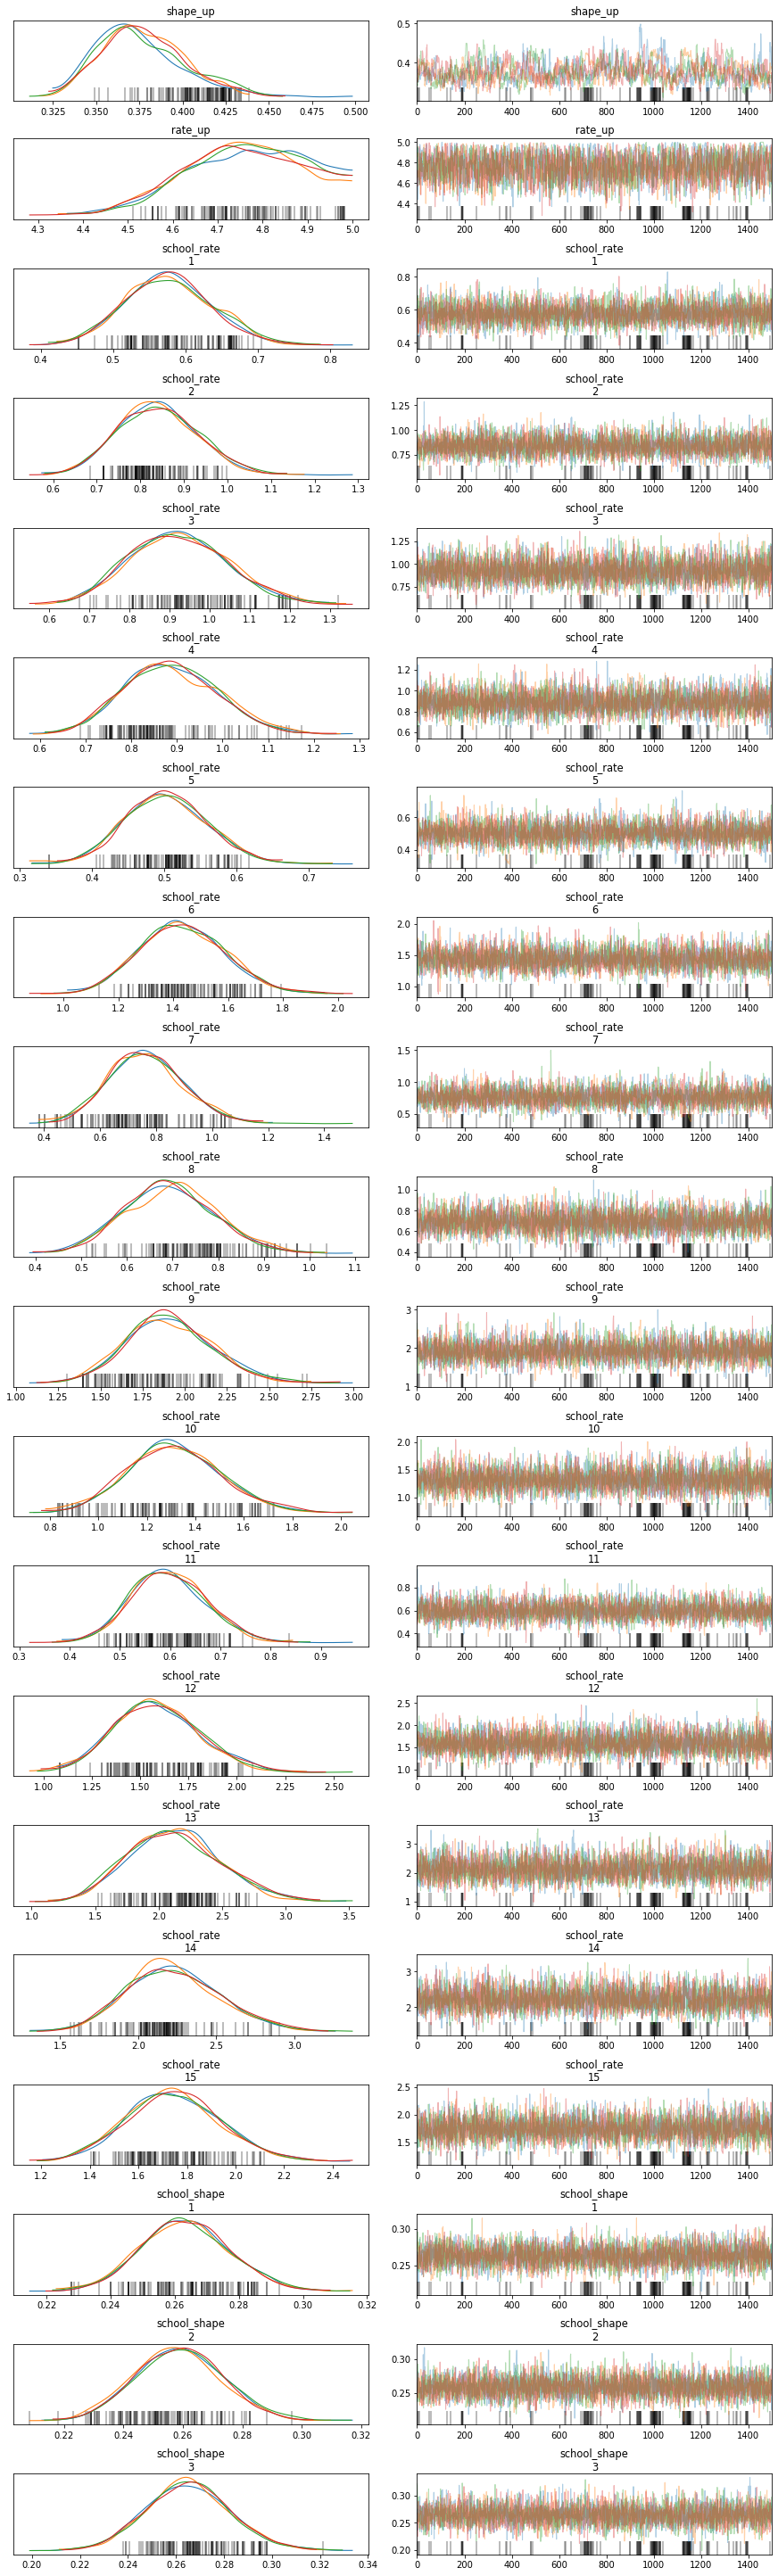

In [7]:
az.plot_trace(simple_idata_normal_a);

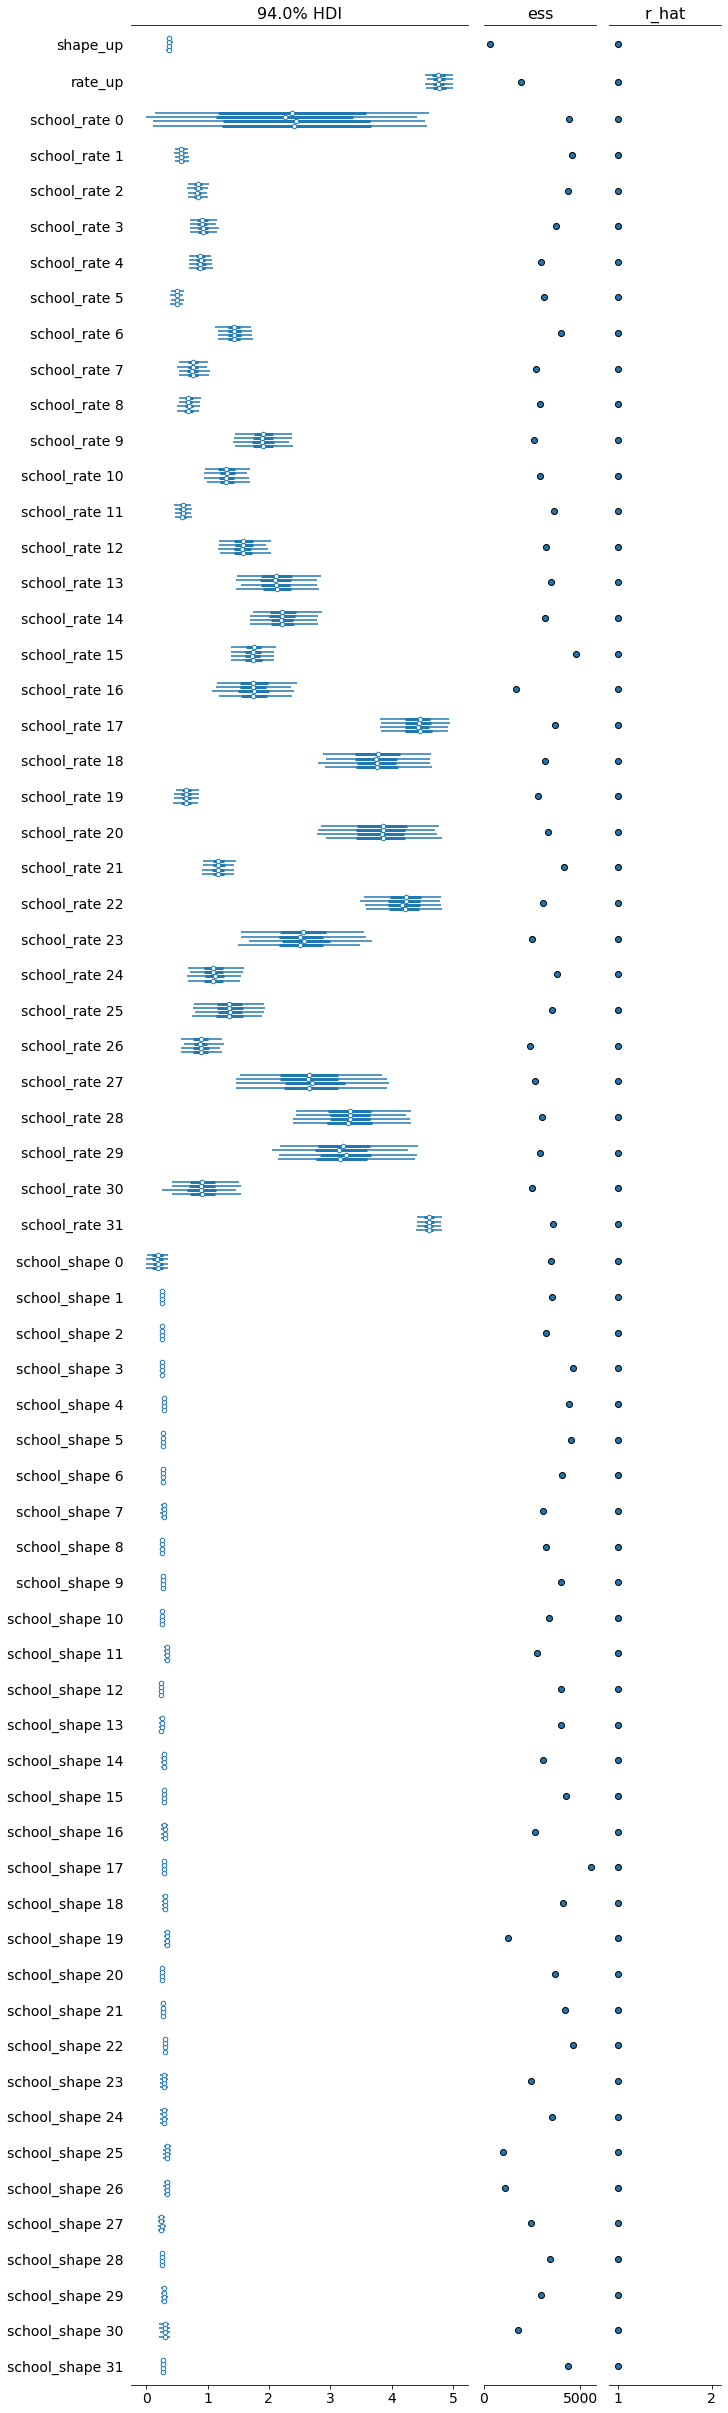

In [8]:
az.plot_forest(simple_idata_normal, r_hat=True, ess=True);

/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:563: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (68) in plot_autocorr, generating only 40 plots
  UserWarning,
/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/plots/plot_utils.py:563: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (72) in plot_autocorr, generating only 40 plots
  UserWarning,


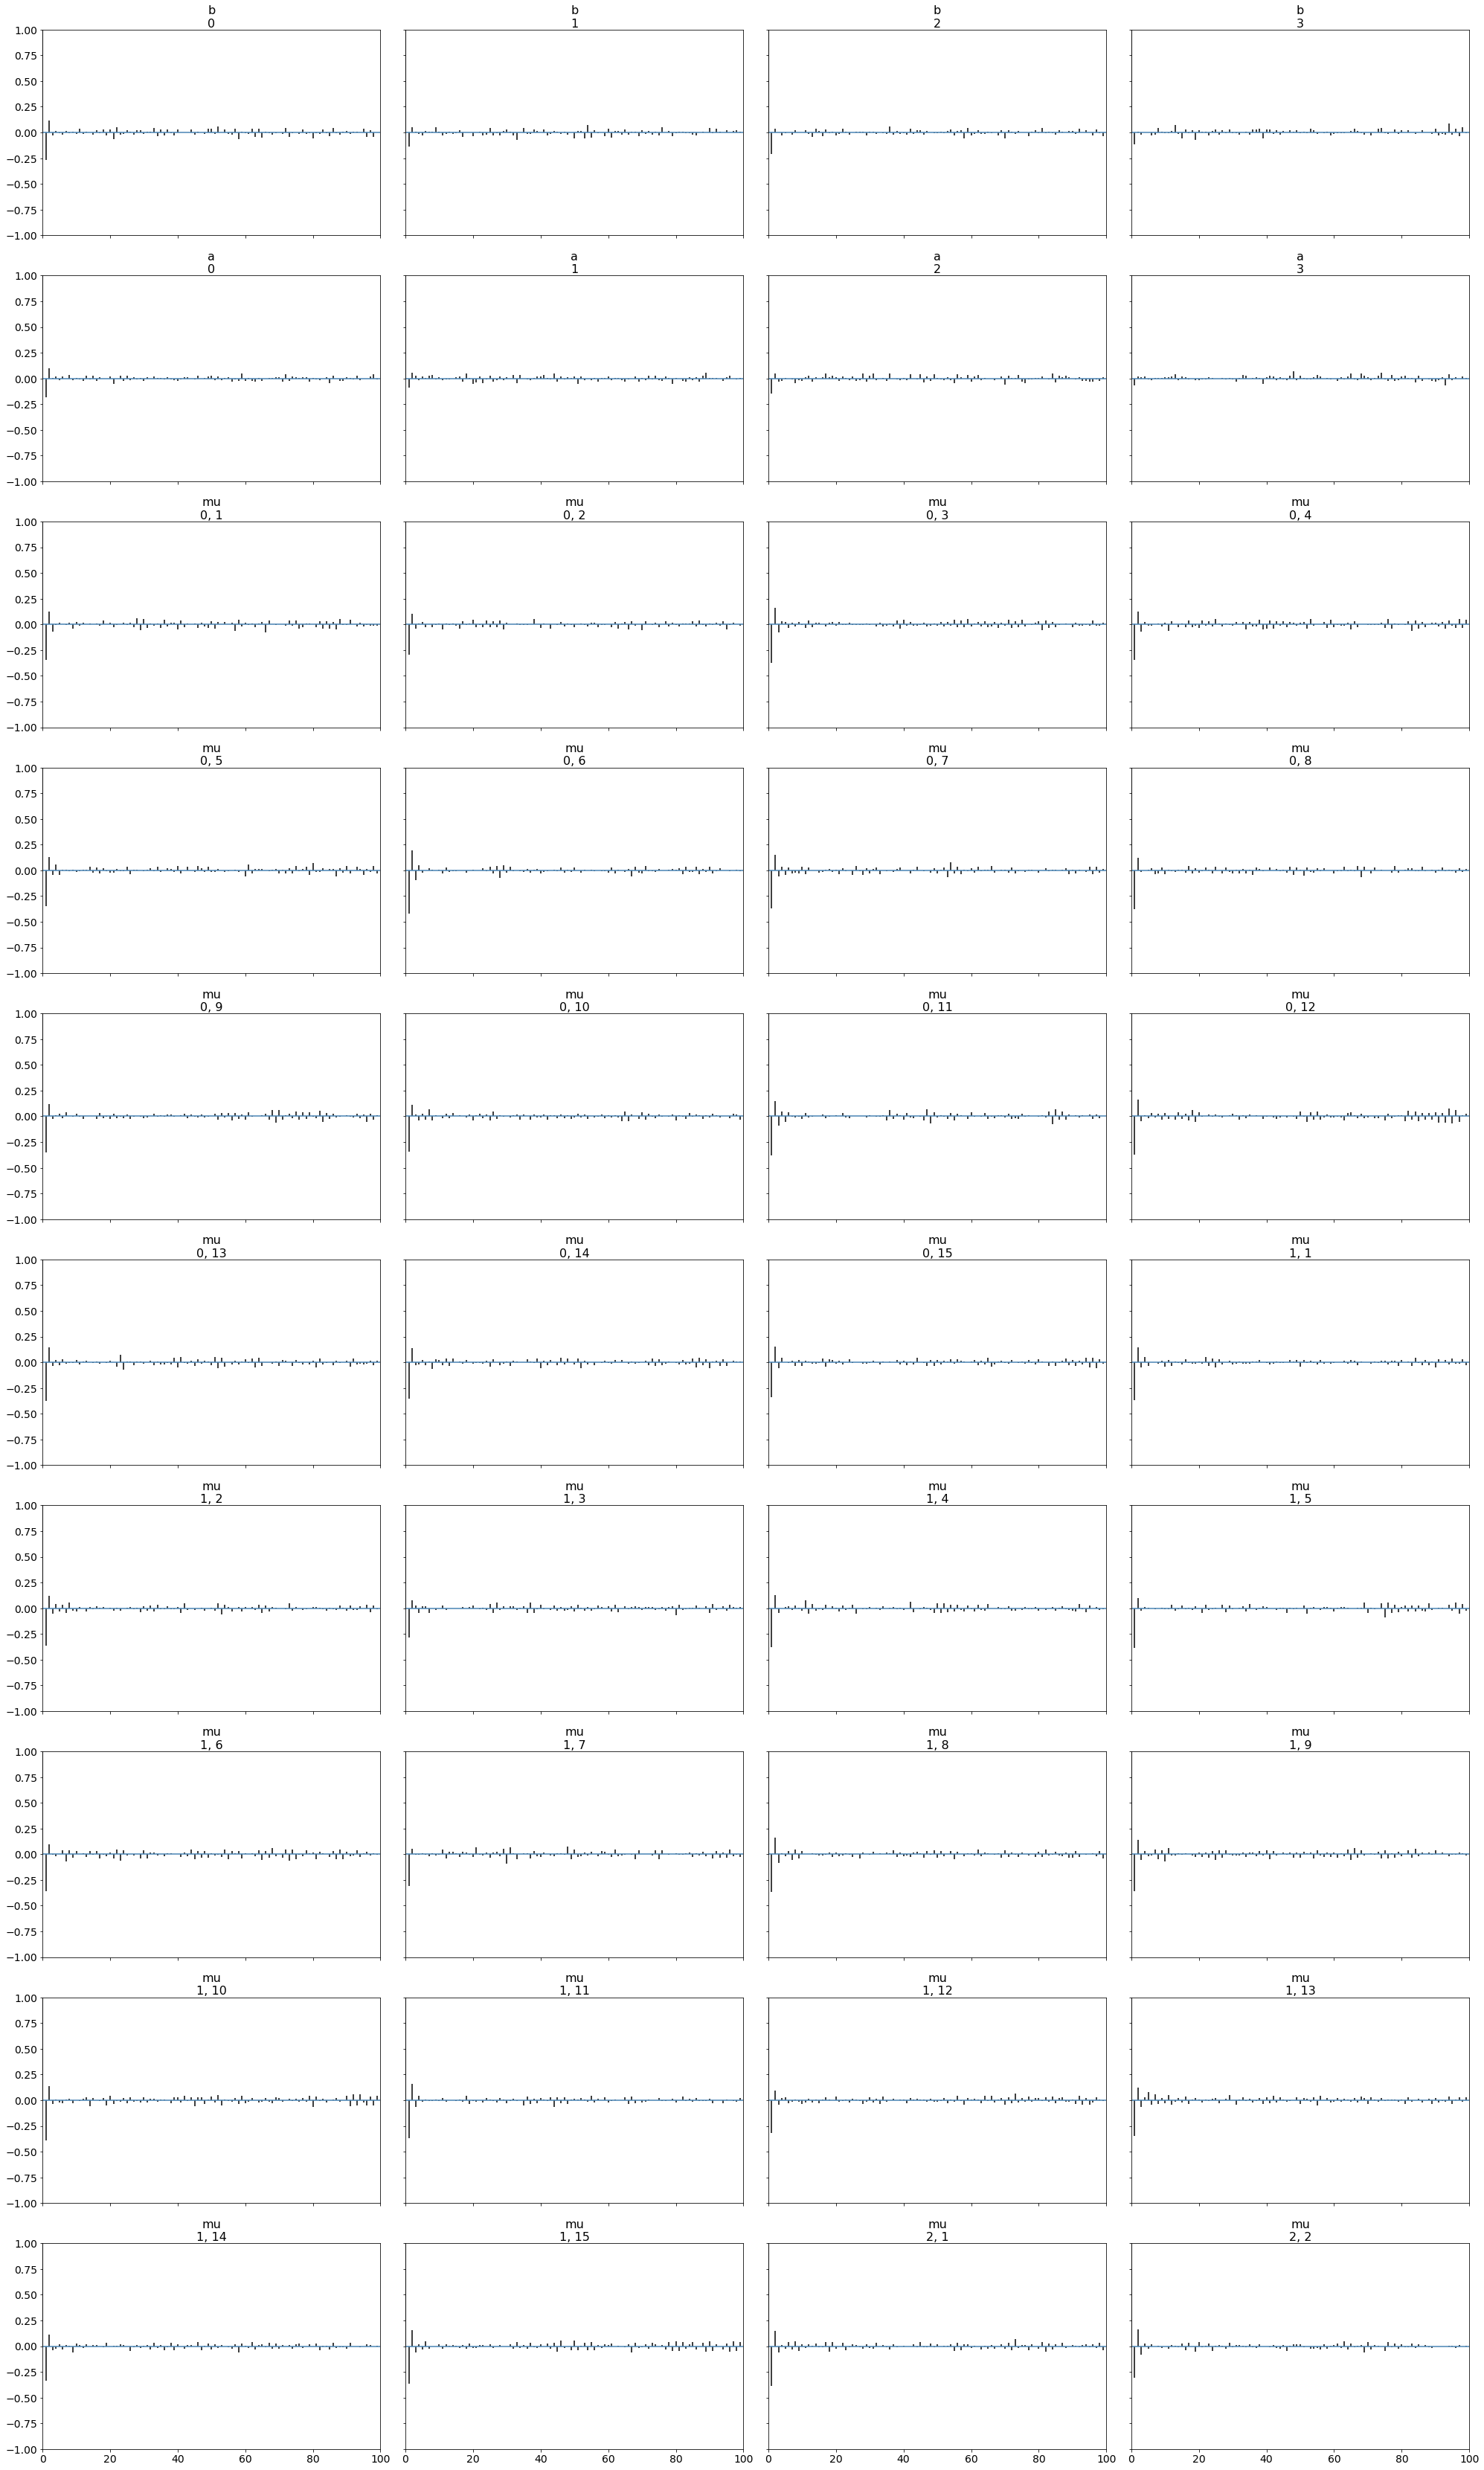

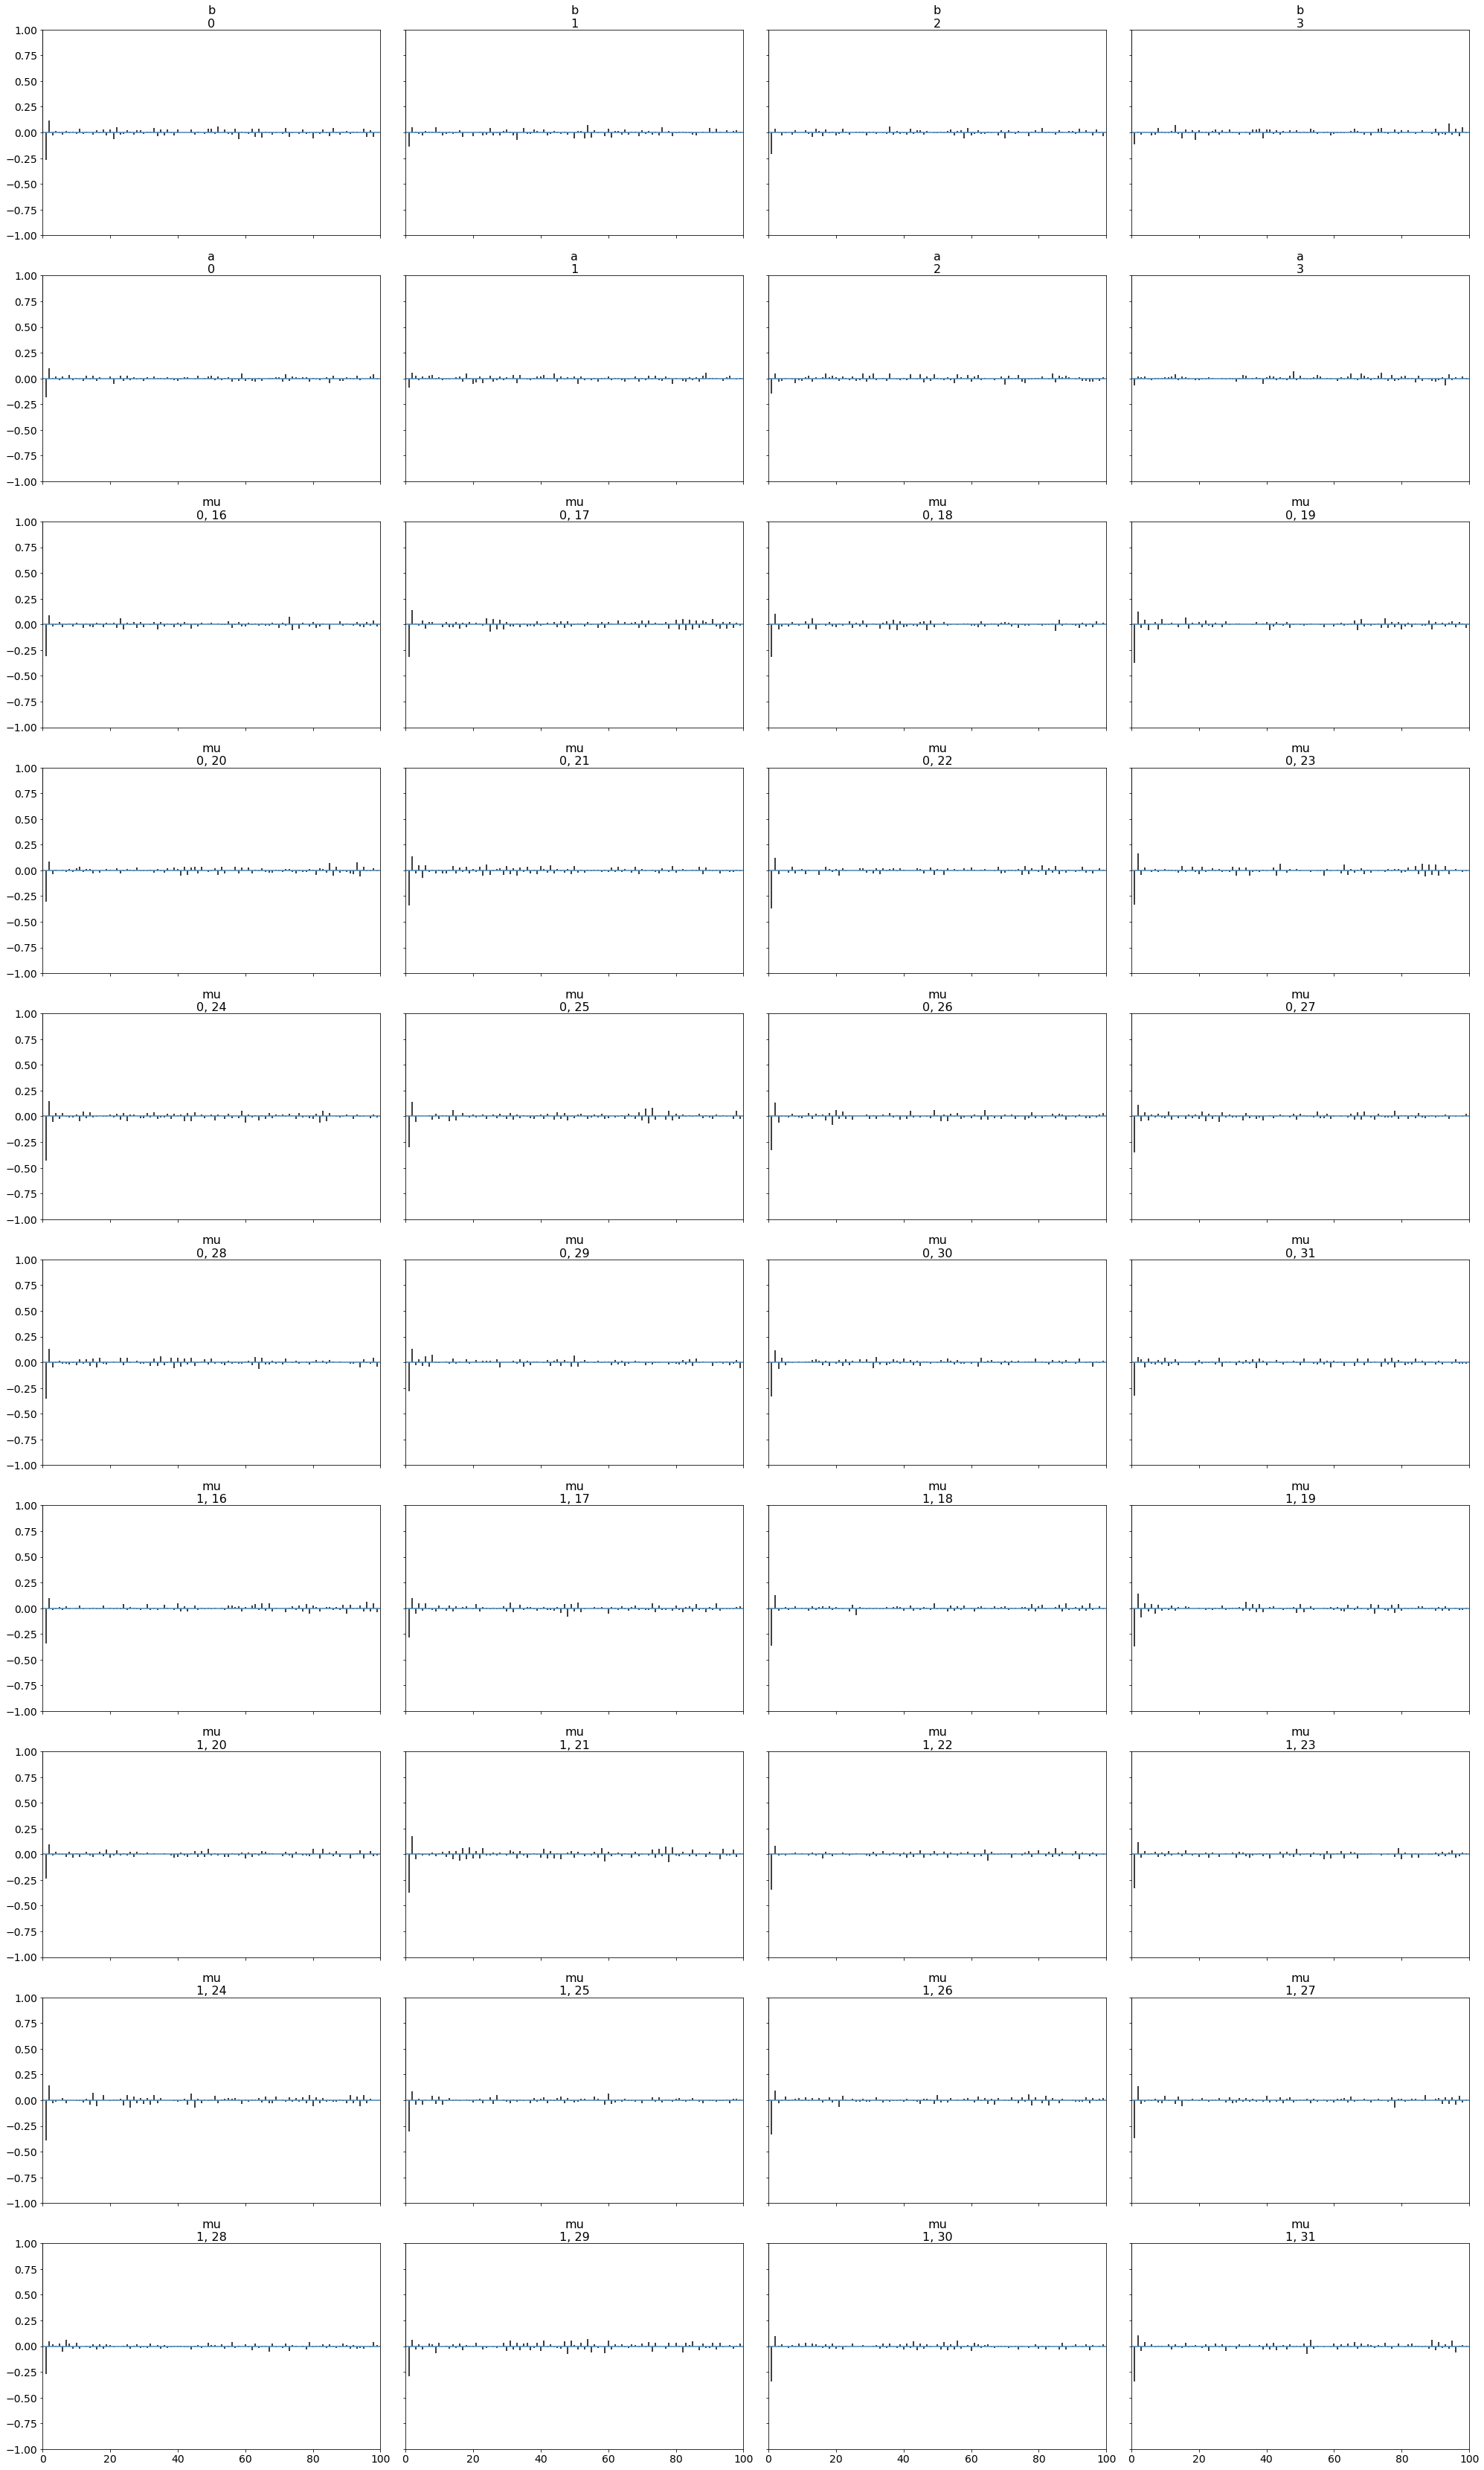

In [74]:
az.plot_autocorr(simple_idata_normal_a);
az.plot_autocorr(simple_idata_normal_b);

### Plot the posterior

See how the model compares to the observed data.

In [19]:
with simple_normal_model:
     py_simple_norm_posterior_samples = pm.sample_posterior_predictive(simple_idata_normal.posterior)

simple_norm_posterior_samples = az.from_pymc3(posterior_predictive = py_simple_norm_posterior_samples)
concat_simple_posterior_normal = az.concat(simple_idata_normal, simple_norm_posterior_samples, inplace=False)

/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


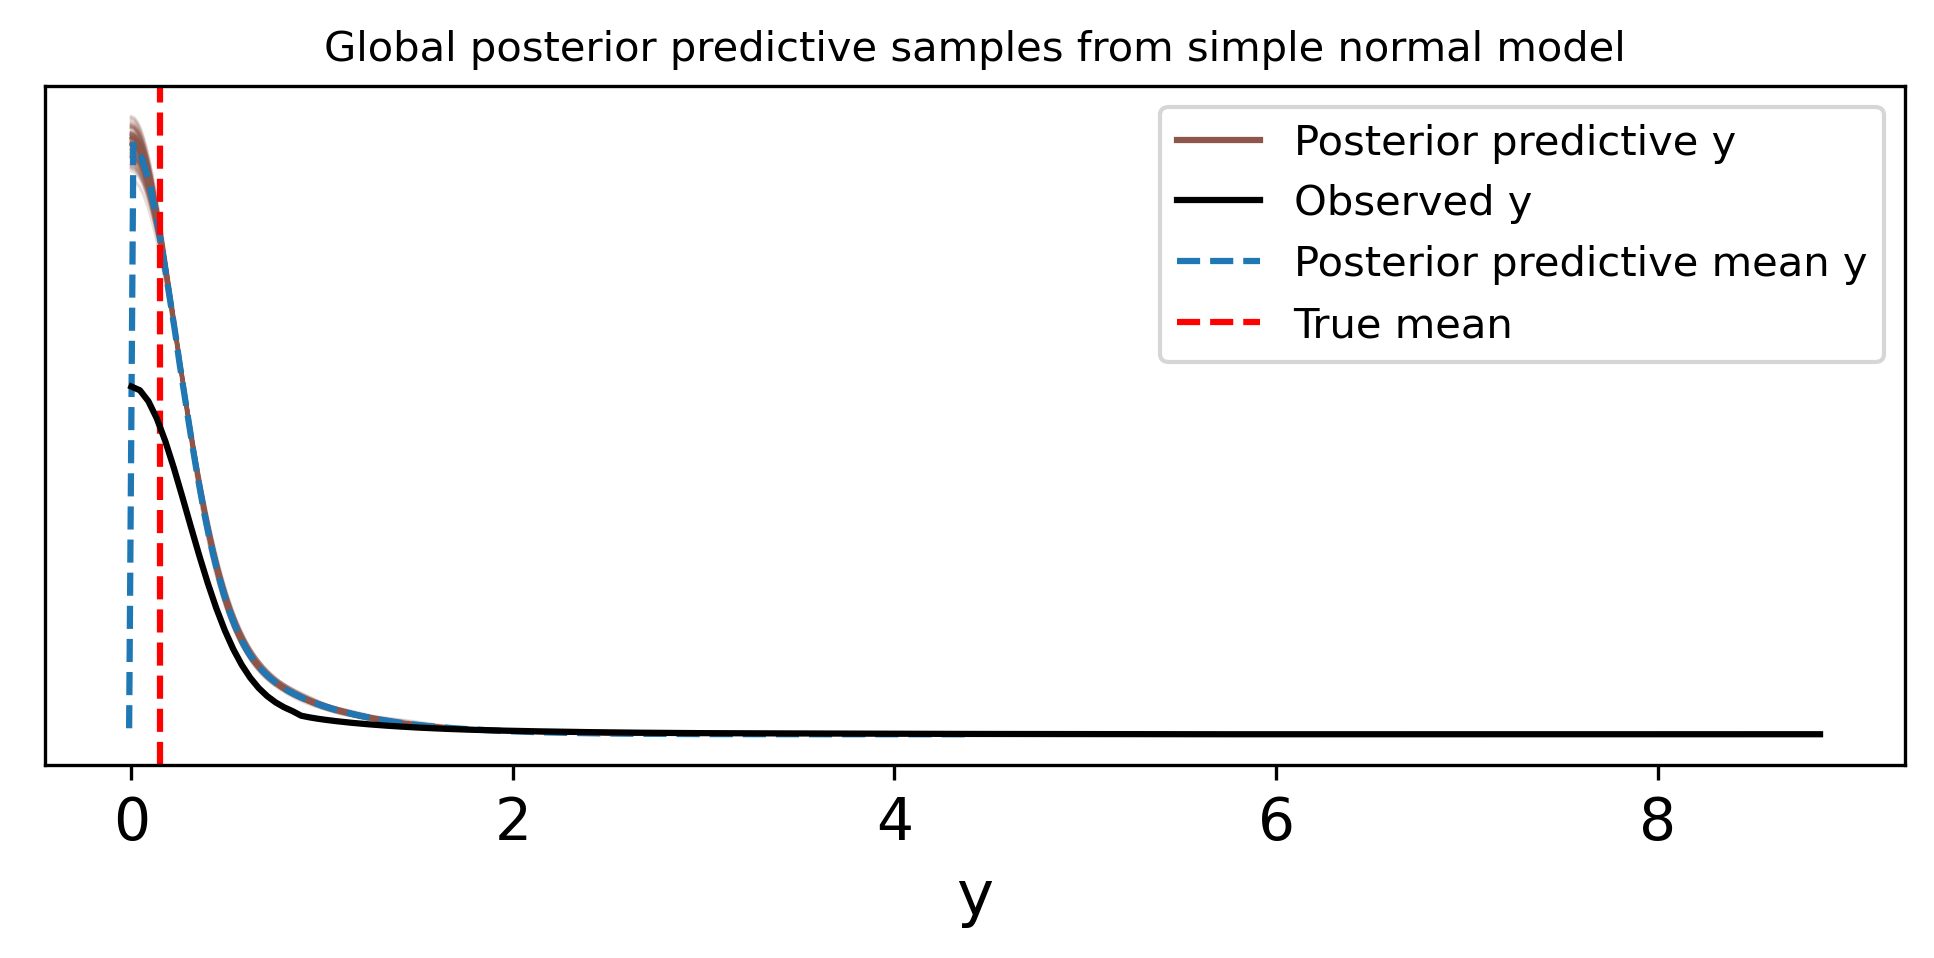

In [20]:
fig, ax = plt.subplots(figsize=(8,3));
fig.set_dpi(300);
az.plot_ppc(concat_simple_posterior_normal, ax=ax, num_pp_samples=100);
ax.axvline(data.AERPub_adj.mean(), ls="--", color="r", label="True mean");
ax.set_title("Global posterior predictive samples from simple normal model", fontsize=10)
ax.legend(fontsize=10, loc=1);

# Multi level model for Normal

Referencing [Doing bayesian data analysis python code](https://nbviewer.jupyter.org/github/JWarmenhoven/DBDA-python/blob/master/Notebooks/Chapter%209.ipynb)

In [4]:
school_idx = data.Rank.values
num_schools = 32
num_grads = data.shape[0]

In [5]:
with pm.Model() as mlm_normal_model:
    # Hyper parameters
    omega = pm.Beta("omega", 1,1)
    scale_k = 0.01
    rate_k = 0.01
    kappa_minus2 = pm.Gamma("kappa_minus2", scale_k, scale_k)
    kappa = pm.Deterministic("kappa", kappa_minus2 + 2)
    
    # School parameters
    omega_school = pm.Beta("omega_school",
                           omega * (kappa - 2) + 1,
                           (1 - omega)*(kappa-2) + 1,
                           shape = num_schools)
    
    kappa_school_minus2 = pm.Gamma("kappa_school_minus_2", scale_k, rate_k, shape = num_schools)
    kappa_school = pm.Deterministic("kappa_school", kappa_school_minus2 + 2)

    # Params for graduates
    sigma_school = pm.Beta("sigma",
                          omega_school[school_idx] * (kappa_school[school_idx] - 2) + 1,
                          (1 - omega_school[school_idx]) * (kappa_school[school_idx]-2) + 1,
                           shape = num_grads)                          
    y = pm.HalfNormal("y", sd=sigma_school, observed=data.AERPub_adj)

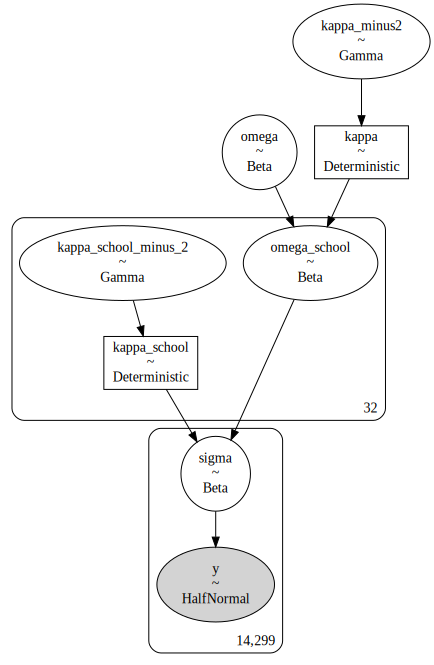

In [6]:
pm.model_to_graphviz(mlm_normal_model)

In [7]:
with mlm_normal_model:
    samples = pm.sample(draws=1500, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, kappa_school_minus_2, omega_school, kappa_minus2, omega]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 2215 seconds.
There were 1494 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9518272451924477, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1490 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1490 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1498 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
samples.to_netcdf("raw_data/mlm_normal_model.nc")

'raw_data/mlm_normal_model.nc'

In [9]:
az.summary(samples)

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
omega               0.000    0.000    0.000     0.000      0.000    0.000   
kappa_minus2     1060.048  287.629  554.023  1613.467     23.525   16.667   
kappa            1062.048  287.629  556.023  1615.467     23.525   16.667   
omega_school[0]     0.001    0.001    0.000     0.003      0.000    0.000   
omega_school[1]     0.001    0.001    0.000     0.003      0.000    0.000   
...                   ...      ...      ...       ...        ...      ...   
sigma[14294]        0.014    0.021    0.000     0.047      0.001    0.001   
sigma[14295]        0.014    0.021    0.000     0.055      0.002    0.001   
sigma[14296]        0.013    0.019    0.000     0.045      0.001    0.001   
sigma[14297]        0.013    0.022    0.000     0.049      0.001    0.001   
sigma[14298]        0.014    0.022    0.000     0.054      0.001    0.001   

                 ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
omega                53.0    53.0      39.0     305.0   1.08  
kappa_minus2        149.0   149.0     144.0     262.0   1.06  
kappa               149.0   149.0     144.0     262.0   1.06  
omega_school[0]     323.0   323.0     207.0     209.0   1.02  
omega_school[1]     321.0   321.0     242.0     311.0   1.01  
...                   ...     ...       ...       ...    ...  
sigma[14294]        483.0   483.0     385.0     781.0   1.01  
sigma[14295]        126.0   126.0      88.0     559.0   1.05  
sigma[14296]        382.0   382.0     323.0     820.0   1.01  
sigma[14297]        479.0   479.0     315.0     820.0   1.01  
sigma[14298]        246.0   246.0     215.0     411.0   1.02  

[14398 rows x 11 columns]

/home/mfritze/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (14363), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f342e7ea950>,
      dtype=object)

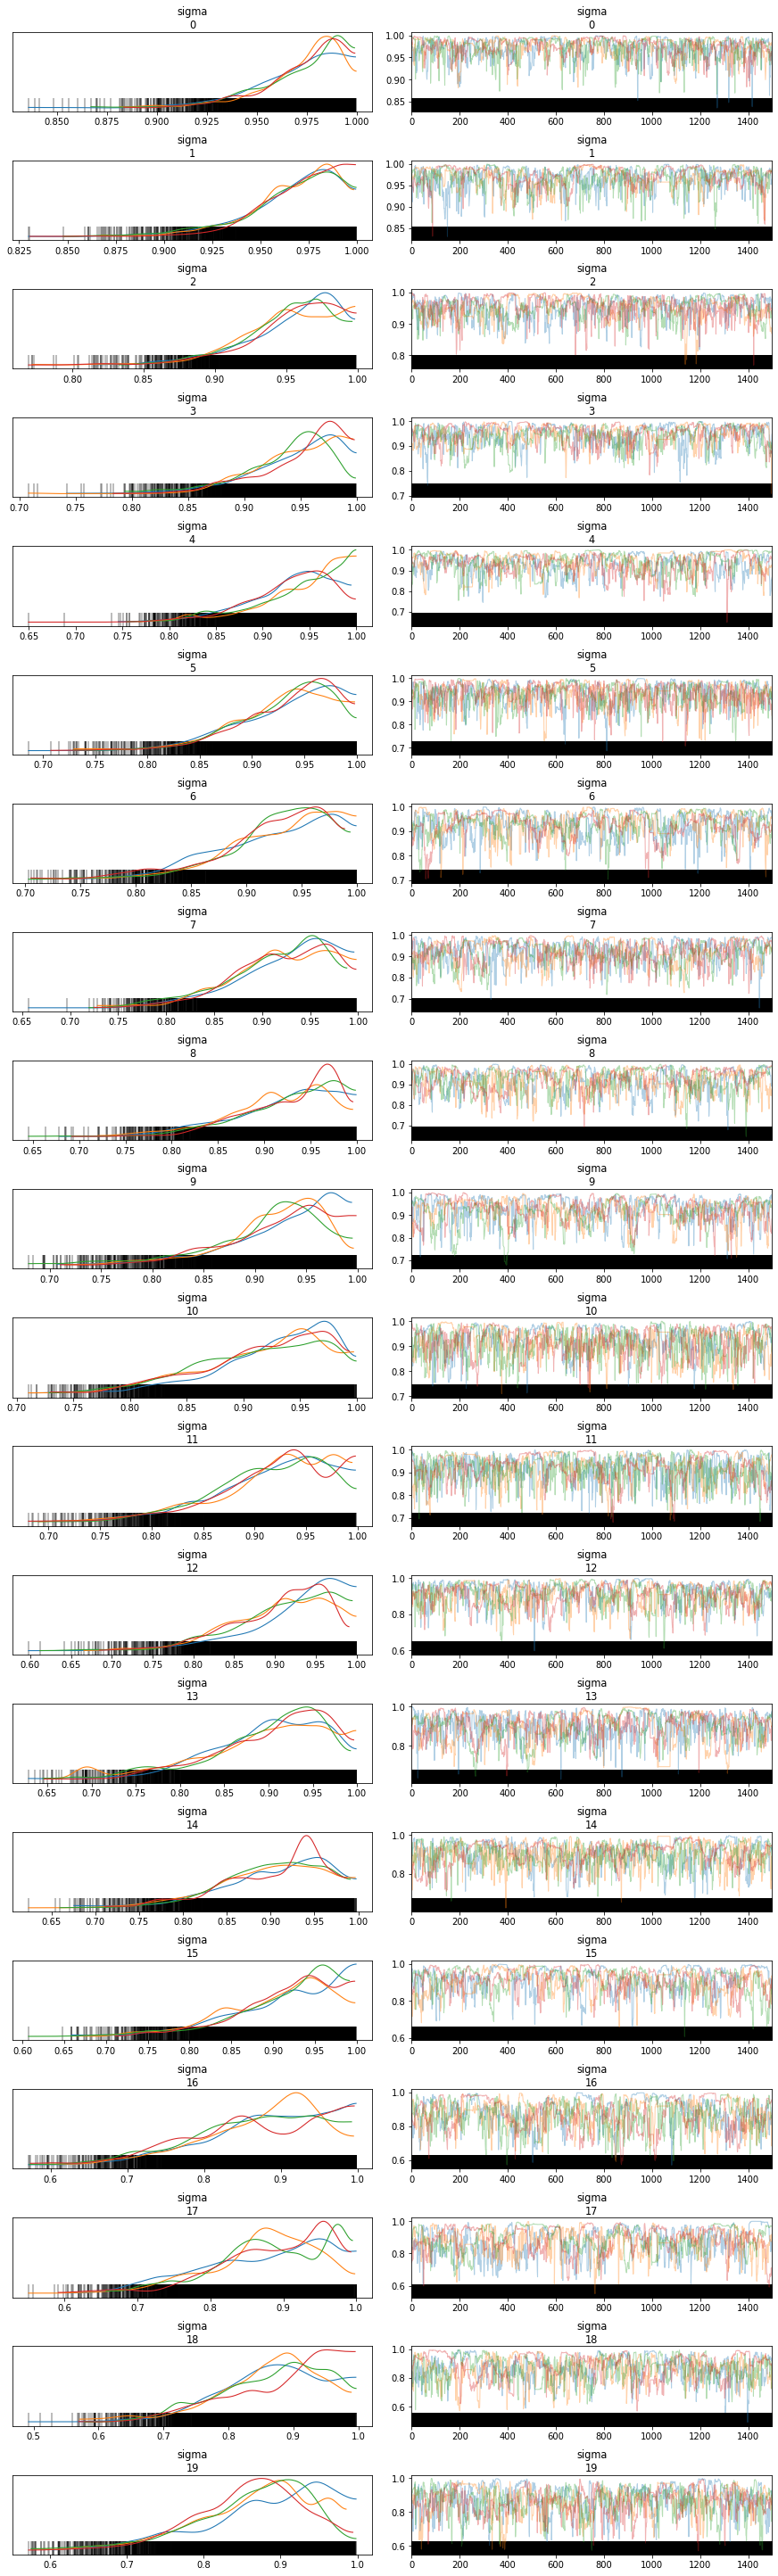

In [10]:
az.plot_trace(samples, ["sigma", "kappa_school", "omega_school"])